# Dataset Reduction Depending on Structure Scale

In this _Jupyter Notebook_, we will reduce the size of datasets representing _Gaussian Random Fields_ using various techniques and investigate how much error is acquired. These techniques can be useful when the original dataset is very large and performing analyses on it is computationally costly. The results from the calculations performed here are reported in an SSDBM conference article [3].

## Initialisation

We start by setting up the necessary tools.

### Imports

The following modules are required in this _Jupyter Notebook_.

In [1]:
import gc
import math
import numpy
import scipy
import scipy.linalg
import sklearn.preprocessing
import matplotlib.pyplot
import copy
import pysal

## Functions

The following functions will be used throughout this _Jupyter Notebook_. Some are based on standard matrix algebra [6, 7, 8].

### Helper Functions

The _loop_ function runs the function given as the first argument multiple times, until the uncertainty in the mean of the results of that function is below a certain threshold.

In [2]:
def loop(function, args={}):
    results = [function(**args) for i in range(5)]
    while numpy.amax(numpy.std(results, axis=0)) / len(results) > 0.01 and len(results) < 100:
        results.append(function(**args))
    return numpy.mean(results, axis=0)

The _reduceUSV_ function takes the output of an _SVD_ and removes the smallest _singular values_.

In [3]:
def reduceUSV(U, s, Vt, p):
    U = U[:, :p]
    s = s[:p]
    Vt = Vt[:p]
    return U, s, Vt

The _usvToMatrix_ function takes the output of an _SVD_ and reconstructs the original matrix.

In [4]:
def usvToMatrix(U, s, Vt):
    return U @ numpy.diag(s) @ Vt

The _usvToReducedMatrix_ function combines the previous two functions by reconstructing the original matrix, except for the smallest _singular values_.

In [5]:
def usvToReducedMatrix(U, s, Vt, p):
    U, s, Vt = reduceUSV(U, s, Vt, p)
    return usvToMatrix(U, s, Vt)

The _reduceMatrix_ function performs an _SVD_ on the input matrix, reduces its dimensionality and then reconstructs the matrix.

In [6]:
def reduceMatrix(A, p):
    U, s, Vt = scipy.linalg.svd(A, full_matrices = False)
    return usvToReducedMatrix(U, s, Vt, p)

The _centerAndStandardiseField_ function centers and standardises the input matrix by row.

In [7]:
def centerAndStandardiseField(matrix):
    return (matrix - numpy.mean(matrix, axis=1)[:, None]) / numpy.std(matrix, axis=1)[:, None]

The _flattenSpatialTemporalFields_ function reshapes two 3D matrices into two 2D matrices.

In [8]:
def flattenSpatialTemporalFields(matrix1, matrix2):
    h, w, d = matrix1.shape
    result1 = matrix1.reshape(h * w, d)
    h, w, d = matrix2.shape
    result2 = matrix2.reshape(h * w, d)
    return result1, result2

The _splitSpatialTemporalField_ function splits a 3D matrix into two 3D matrices by taking alternating slices in the third dimension, which is time.

In [9]:
def splitSpatialTemporalField(matrixCombined):
    h, w, d = matrixCombined.shape
    d1 = numpy.arange(0, d, 2)
    d2 = numpy.arange(1, d, 2)
    matrix1 = matrixCombined[:, :, d1]
    matrix2 = matrixCombined[:, :, d2]
    return matrix1, matrix2

The _splitAndFlattenSpatialTemporalField_ function combines the previous two functions.

In [10]:
def splitAndFlattenSpatialTemporalField(matrixCombined):
    matrix1, matrix2 = splitSpatialTemporalField(matrixCombined)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrix1, matrix2)
    return matrixFlattened1, matrixFlattened2

The _addRectangle_ function adds a rectangle to a plot with some text in the middle.

In [11]:
def addRectangle(axis, left, width, height, text, type=None):
    right = left + width
    patch = matplotlib.patches.Rectangle(
        (left, 1-height), width, height,
        fill=False, clip_on=False
        )
    axis.add_patch(patch)
    axis.text(0.5*(left+right), 1-0.5*height, text,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=14)
    left = right + 0.1
    return axis, left

The _addSymbol_ function adds a symbol, or string of text, to a plot.

In [12]:
def addSymbol(axis, left, symbol, width=0.3, left2=0.1, type=None):
    axis.text(left + left2,
              0.85, symbol,
              horizontalalignment='center',
              verticalalignment='center',
              fontsize=14)
    left = left + width
    return axis, left

The _plotMatrixMultiplication_ function takes as input a description of some matrix multiplication and combines the previous two function to make a plot of the mathematics.

In [13]:
def plotMatrixMultiplication(matrixDescription=[{}], filePath=None):
    figure, axis = matplotlib.pyplot.subplots()
    matplotlib.pyplot.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    matplotlib.pyplot.axis('off')
    figure.set_size_inches(1.5, 1.5)
    left = 0
    for args in matrixDescription:
        if args["type"] is "Matrix":
            axis, left = addRectangle(axis, left, **args)
        elif args["type"] is "Symbol":
            axis, left = addSymbol(axis, left, **args)
    if filePath is not None:
        matplotlib.pyplot.savefig(filePath, bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

### Gaussian Random Spatial Field

The _gaussianRandomSpatialField_ function generates a 2D matrix representing a _Gaussian Random Field_ where the power spectrum follows a power law with exponent -$\alpha$. The resulting matrix is scaled such that it has zero mean and unit standard deviation.

In [14]:
def gaussianRandomSpatialField(alpha=2.0, size=100):
    # Based on: http://andrewwalker.github.io/statefultransitions/post/gaussian-fields/
    noise = numpy.fft.fft2(numpy.random.normal(size=(size, size)))
    mesh = numpy.meshgrid(range(-size//2, size//2), range(-size//2, size//2))
    distance = numpy.power(mesh[0], 2, dtype=numpy.float64) + numpy.power(mesh[1], 2, dtype=numpy.float64)
    distance[size//2, size//2] = numpy.inf
    amplitude = numpy.power(distance, -alpha/2)
    amplitude = numpy.fft.ifftshift(amplitude)
    result = numpy.fft.ifft2(noise * amplitude).real
    result = (result - numpy.mean(result)) / numpy.std(result)
    return result

The _singular values_ of a matrix represent the amount of variance in the original dataset explained by the associated singular mode. The _explainedVariance_ function takes the list of _singular values_ and returns a list of explained variance. This can e.g. be used in a plot.

In [15]:
def explainedVariance(s):
    x = numpy.arange(1, len(s) + 1)
    total = s.T @ s
    cumulativeValue = 0
    valueList = numpy.square(s) / total
    cumulativeList = numpy.cumsum(valueList)
    mask = valueList > 10**-3
    x = x[mask]
    valueList = valueList[mask]
    cumulativeList = cumulativeList[mask]
    return x, valueList, cumulativeList

The _getGaussianPowerSpectrum_ function takes a 2D matrix, assumes it represents a rotationally invariant _Gaussian Random Field_ and return the power spectrum of the field.

In [16]:
def getGaussianPowerSpectrum(dataArray):
    if len(dataArray.shape) == 3:
        h, w, d = dataArray.shape
        mesh = numpy.meshgrid(range(-h//2, h//2), range(-w//2, w//2), range(-d//2, d//2))
        wavesFlattened = (numpy.power(mesh[0], 2) + numpy.power(mesh[1], 2) + numpy.power(mesh[2], 2)).flatten()
    else:
        h, w = dataArray.shape
        mesh = numpy.meshgrid(range(-h//2, h//2), range(-w//2, w//2))
        wavesFlattened = numpy.power(numpy.power(mesh[0], 2) + numpy.power(mesh[1], 2), 1/2).flatten()
    fft = numpy.fft.fftn(dataArray)
    fftShifted = numpy.fft.fftshift(fft)
    fftAbs = numpy.abs(fftShifted)
    fftFlattened = fftAbs.flatten()
    mask = wavesFlattened == 0
    wavesMasked = wavesFlattened[~mask]
    fftMasked = fftFlattened[~mask]
    mask2 = numpy.log(fftMasked) < -20
    wavesMasked2 = wavesMasked[~mask2]
    fftMasked2 = fftMasked[~mask2]
    return wavesMasked2, fftMasked2

The _estimateGaussianPowerLaw_ function takes a 2D matrix, assumes it represents a rotationally invariant _Gaussian Random Field_ and estimates the exponent of the power law which fits the power spectrum of the field.

In [17]:
def estimateGaussianPowerLaw(dataArray, wavesMasked=None, fftMasked=None):
    if wavesMasked is None or fftMasked is None:
        wavesMasked, fftMasked = getGaussianPowerSpectrum(dataArray)
    wavesLog = numpy.log(wavesMasked)
    fftLog = numpy.log(fftMasked)
    estimatedAlpha, estimatedIntercept, r_value, p_value, std_err = scipy.stats.linregress(wavesLog, fftLog)
    estimatedRSquared = r_value**2
    return -estimatedAlpha, estimatedIntercept, estimatedRSquared

The _estimateSingularValuesPowerLaw_ function takes a 2D matrix, assumes its singular values fit a power law and estimates the exponent of the power law.

In [18]:
def estimateSingularValuesPowerLaw(singularValues):
    x = numpy.log(list(range(1, len(singularValues) + 1)))
    y = numpy.log(singularValues)
    mask = y < -20
    x = x[~mask]
    y = y[~mask]
    estimatedBeta, estimatedIntercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    estimatedBetaRSquared = r_value**2
    return -estimatedBeta, estimatedIntercept, estimatedBetaRSquared

Let's plot some _Gaussian Random Fields_ of various sizes, for various $\alpha$'s. Let's also test the _estimateGaussianPowerLaw_ function by applying it to the generated datasets and comparing the result with the true $\alpha$. As can be seen, the $\alpha$ is a measure of the spatial autocorrelation of the field. In particular, fields with large scale structure have a larger $\alpha$. Additionally, the size of the _singular values_ can be plotted. This is related to the power spectrum and will also provide information about the scale of the structure in the field. Finally, there are other measures of spatial autocorrelation. These include the $\Gamma$ Index and Moran's $I$. The Python module _pysal_ contains functions to calculate these values. We will include them for each plot [7, 10, 13, 14, 16].

Size: 100 | Alpha: 1.000
Estimated Alpha: 0.955 | r^2: 0.357
Estimated Beta: 1.398 | r^2: 0.983
g.g: 3.069 | g.p_sim_g: 0.001
mi.I: 0.774 | mi.p_rand: 0.000


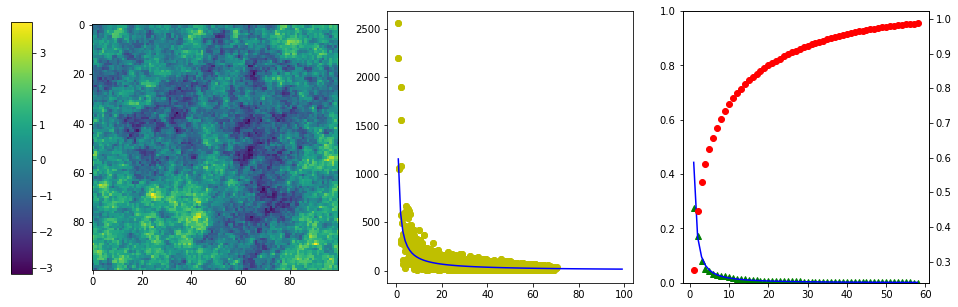

Size: 100 | Alpha: 2.000
Estimated Alpha: 1.985 | r^2: 0.712
Estimated Beta: 3.618 | r^2: 0.933
g.g: 3.945 | g.p_sim_g: 0.001
mi.I: 0.997 | mi.p_rand: 0.000


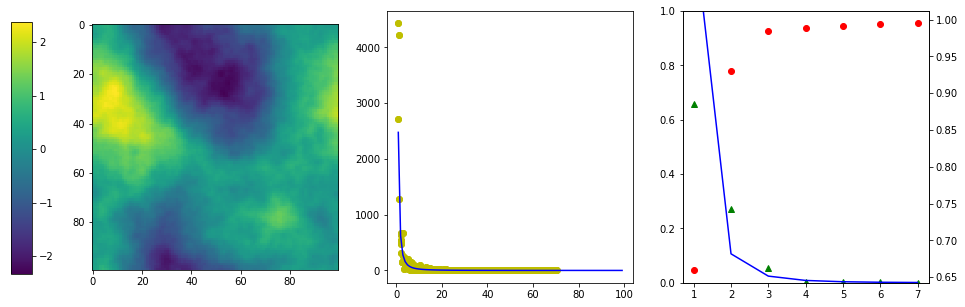

Size: 100 | Alpha: 4.000
Estimated Alpha: 4.015 | r^2: 0.911
Estimated Beta: 4.220 | r^2: 0.970
g.g: 3.974 | g.p_sim_g: 0.001
mi.I: 0.999 | mi.p_rand: 0.000


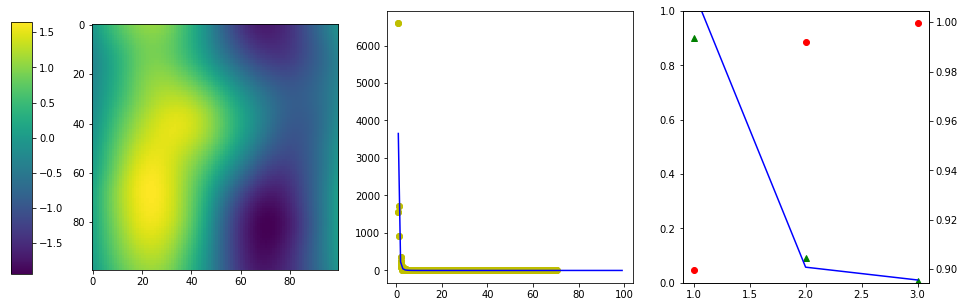

Size: 200 | Alpha: 1.000
Estimated Alpha: 0.989 | r^2: 0.377
Estimated Beta: 1.275 | r^2: 0.992
g.g: 3.179 | g.p_sim_g: 0.001
mi.I: 0.799 | mi.p_rand: 0.000


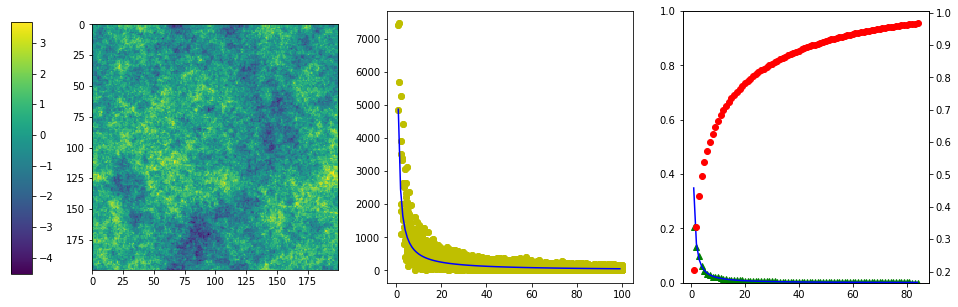

Size: 200 | Alpha: 2.000
Estimated Alpha: 2.006 | r^2: 0.718
Estimated Beta: 2.772 | r^2: 0.924
g.g: 3.959 | g.p_sim_g: 0.001
mi.I: 0.998 | mi.p_rand: 0.000


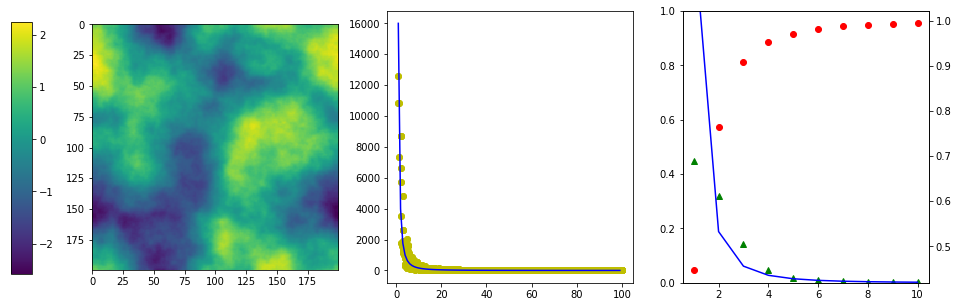

Size: 200 | Alpha: 4.000
Estimated Alpha: 4.004 | r^2: 0.911
Estimated Beta: 5.034 | r^2: 0.761
g.g: 3.981 | g.p_sim_g: 0.001
mi.I: 1.000 | mi.p_rand: 0.000


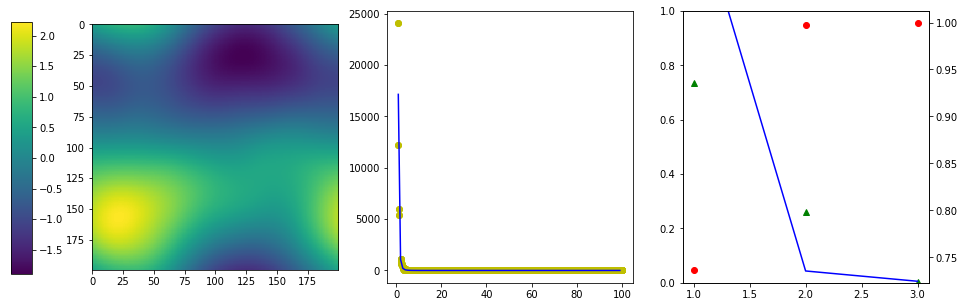

Size: 400 | Alpha: 1.000
Estimated Alpha: 1.003 | r^2: 0.392
Estimated Beta: 1.151 | r^2: 0.995
g.g: 3.222 | g.p_sim_g: 0.001
mi.I: 0.808 | mi.p_rand: 0.000


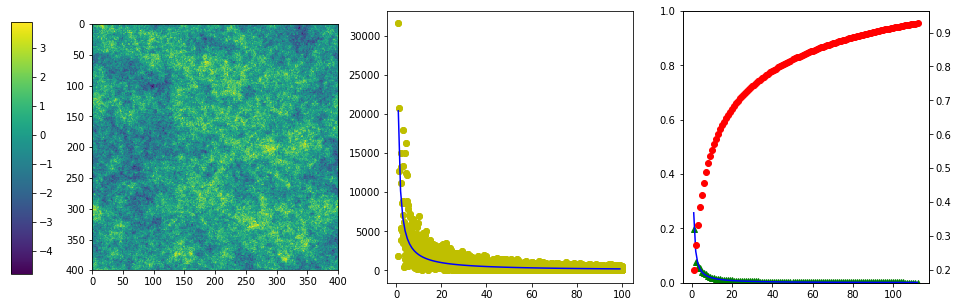

Size: 400 | Alpha: 2.000
Estimated Alpha: 1.998 | r^2: 0.720
Estimated Beta: 3.255 | r^2: 0.952
g.g: 3.991 | g.p_sim_g: 0.001
mi.I: 1.000 | mi.p_rand: 0.000


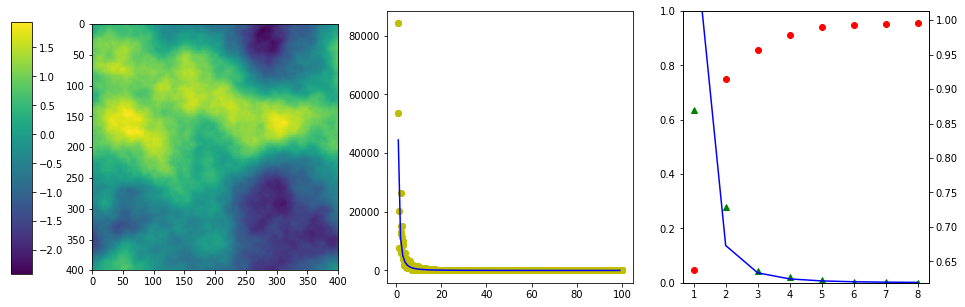

Size: 400 | Alpha: 4.000
Estimated Alpha: 3.995 | r^2: 0.910
Estimated Beta: 4.658 | r^2: 0.687
g.g: 3.990 | g.p_sim_g: 0.001
mi.I: 1.000 | mi.p_rand: 0.000


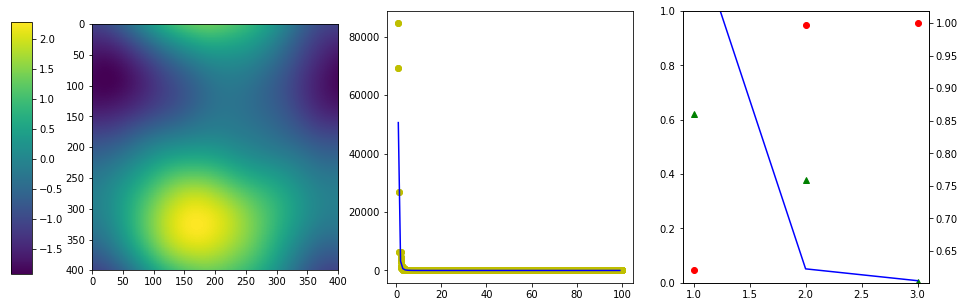

In [19]:
for size in [100, 200, 400]:
    for alpha in [1, 2, 4]:
        data = gaussianRandomSpatialField(alpha, size)
        wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
        estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
        U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
        x, valueList, cumulativeList = explainedVariance(s)
        estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
        y = data.flatten()
        w = pysal.lat2W(size, size)
        g = pysal.Gamma(y, w)
        mi = pysal.Moran(y, w)
        print("Size: {:d} | Alpha: {:0.3f}".format(size, alpha))
        print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
        print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
        print("g.g: {:0.3f} | g.p_sim_g: {:0.3f}".format(g.g/size**2, g.p_sim_g))
        print("mi.I: {:0.3f} | mi.p_rand: {:0.3f}".format(mi.I, mi.p_rand))
        fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
        im = ax1.imshow(data)
        extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        ax1.axis('off')
        fig.savefig("Results/GaussianRandomFieldSize{:d}Alpha{:d}.pdf".format(size, alpha), bbox_inches=extent, pad_inches=0)
        ax1.axis('on')
        cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax = cbaxes)
        ax2.plot(wavesMasked[wavesMasked<100], fftMasked[wavesMasked<100], "yo")
        ax2.plot(range(1, 100), math.exp(estimatedIntercept) * numpy.power(range(1, 100), -estimatedAlpha), "b-")
        ax3.plot(x, valueList, "g^")
        ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
        ax3.set_ylim(0, valueList[0])
        ax3b = ax3.twinx()
        ax3.set_ylim(0, 1)
        ax3b.plot(x, cumulativeList, "ro")
        matplotlib.pyplot.show()

To find a more precise relation between the $\alpha$ of a _Gaussian Random Fields_ and the other measures of spatial autocorrelation, let's generate various fields for different sizes and different $\alpha$'s. We can then calculate $\beta$, the $\Gamma$ Index and Moran's $I$ as a function of $\alpha$.

In [20]:
def testGammaAndMoransIAndBeta(size=100, alpha=2):
    data = gaussianRandomSpatialField(alpha, size)
    U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
    estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(s)
    y = data.flatten()
    w = pysal.lat2W(size, size)
    g = pysal.Gamma(y, w)
    mi = pysal.Moran(y, w)
    return g.g/size**2, mi.I, estimatedBeta

The following two numbers are the $\Gamma$ Index, divided by the size of the matrix, and Moran's $I$. By varying the size and the $\alpha$, we can find their dependency on these parameters.

In [21]:
loop(testGammaAndMoransIAndBeta)

array([ 3.94592622,  0.9955961 ,  1.94634677])

As expected, it seems a smaller matrix size does not result in any relevant changes in the $\Gamma$ Index nor in Moran's $I$.

In [22]:
loop(testGammaAndMoransIAndBeta, {"size": 50})

array([ 3.86611524,  0.98652748,  1.98957845])

We can conclude that these measures are, above a minimum size, independent of size.

In [23]:
loop(testGammaAndMoransIAndBeta, {"size": 200})

array([ 3.97249342,  0.99828901,  1.89815837])

When $\alpha$ is smaller, the _Gaussian Random Field_ has smaller scale structure. It is closer to randomness and has less autocorrelation. As expected, this can be seen in the two measures of autocorrelation, which are now smaller.

In [24]:
loop(testGammaAndMoransIAndBeta, {"alpha": 1})

array([ 2.98400408,  0.75410823,  1.13898455])

Similarly, a larger $\alpha$ results in larger values for the two measures of autocorrelation.

In [25]:
loop(testGammaAndMoransIAndBeta, {"alpha": 4})

array([ 3.95722754,  0.9989459 ,  3.83533257])

We can also plot the relation between $\alpha$, the $\Gamma$ Index weighted by size, Moran's $I$ and $\beta$.

In [26]:
def plotGammaAndMoransIAndBeta(size=100):
    alphas = numpy.arange(0.25, 3.1, 0.25)
    line = []
    line2 = []
    line3 = []
    for alpha in alphas:
        value = loop(testGammaAndMoransIAndBeta, {"size": size, "alpha": alpha})
        line.append(value[0])
        line2.append(value[1])
        line3.append(value[2])
    matplotlib.pyplot.plot(alphas, line)
    matplotlib.pyplot.plot(alphas, line2)
    matplotlib.pyplot.plot(alphas, line3)
    matplotlib.pyplot.legend(["$\Gamma$ per size", "Moran's $I$", r"$\beta$"])
    matplotlib.pyplot.xlabel(r"$\alpha$")
    matplotlib.pyplot.ylabel("autocorrelation")
    matplotlib.pyplot.savefig("Results/plotGammaAndMoransIAndBeta.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

The plot below indeed shows the positive correlation of $\alpha$ and with the $\Gamma$ Index, Moran's $I$ and $\beta$. Subsequent analyses will define the scale of the field's structure in terms of $\alpha$. This plot can help _translate_ this measure to the other measures of autocorrelation.

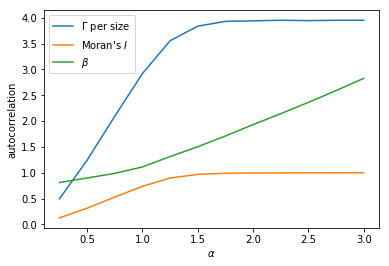

In [27]:
plotGammaAndMoransIAndBeta()

To keep our _Jupyter Notebook_ running efficiently, let's _collect garbage_.

In [28]:
_ = gc.collect()

### Gaussian Random Spatio-Temporal Field

In many real-world applications, the analysis of a field does not only involve a single _time snapshot_. In fact, it often includes data over multiple weeks, months or years, where the field over the entire time period does not change drastically. Just as there is spatial autocorrelation, there is temporal autocorrelation. The _gaussianRandomSpatialTemporalField_ function generates a 3D matrix where the third dimension represent _time_. In principle, there can be a different level of correlation over time than over space. However, for simplicity, we are using the same $\alpha$ determine the level of autocorrelation in all dimensions.

In [29]:
def gaussianRandomSpatialTemporalField(alpha=2.0, spatialSize=100, temporalSize=60):
    noise = numpy.fft.fftn(numpy.random.normal(size=(spatialSize, spatialSize, temporalSize)))
    mesh = numpy.meshgrid(range(-spatialSize//2, spatialSize//2), range(-spatialSize//2, spatialSize//2), range(-temporalSize//2, temporalSize//2))
    distance = numpy.power(mesh[0], 2, dtype=numpy.float64) + numpy.power(mesh[1], 2, dtype=numpy.float64) + numpy.power(mesh[2], 2, dtype=numpy.float64)
    distance[spatialSize//2, spatialSize//2, temporalSize//2] = numpy.inf
    amplitude = numpy.power(distance, -alpha/2)
    amplitude = numpy.fft.ifftshift(amplitude)
    result = numpy.fft.ifftn(noise * amplitude).real
    result = (result - numpy.mean(result)) / numpy.std(result)
    return result

We can plot various _time snapshots_ of a spatial field next to each other, which will show how the field evolves in time. These changes will occur rapidly for smaller $\alpha$ and slower for larger $\alpha$. The _estimateGaussianPowerLaw_ function can, again, be used to estimate $\alpha$ a posteriori.

Spatial Size: 100 | Alpha: 1.000
Estimated Alpha: 0.499 | r^2: 0.382


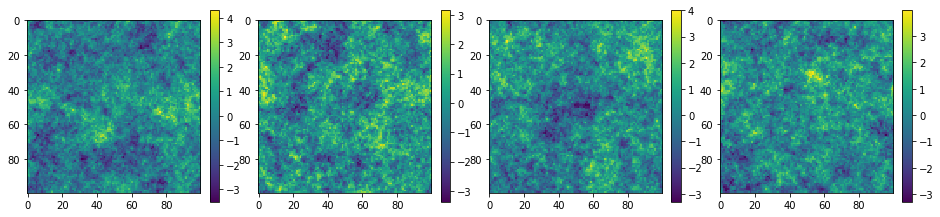

Spatial Size: 100 | Alpha: 2.000
Estimated Alpha: 1.005 | r^2: 0.719


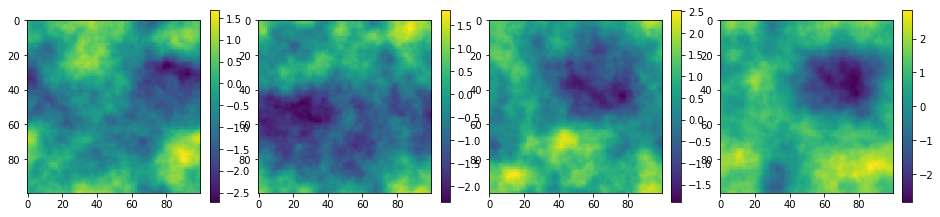

Spatial Size: 100 | Alpha: 4.000
Estimated Alpha: 1.997 | r^2: 0.909


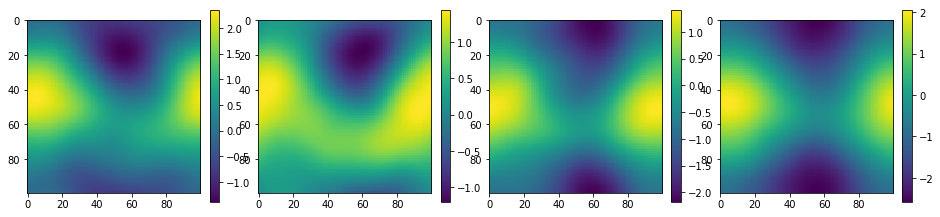

Spatial Size: 200 | Alpha: 1.000
Estimated Alpha: 0.497 | r^2: 0.383


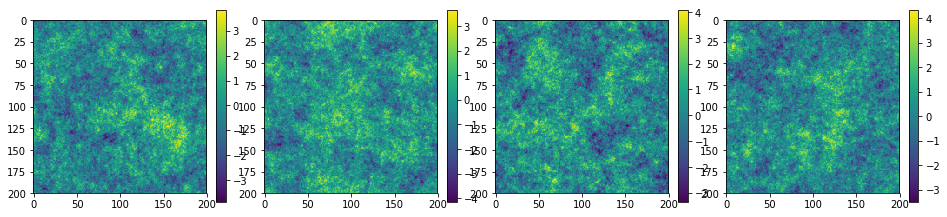

Spatial Size: 200 | Alpha: 2.000
Estimated Alpha: 1.000 | r^2: 0.716


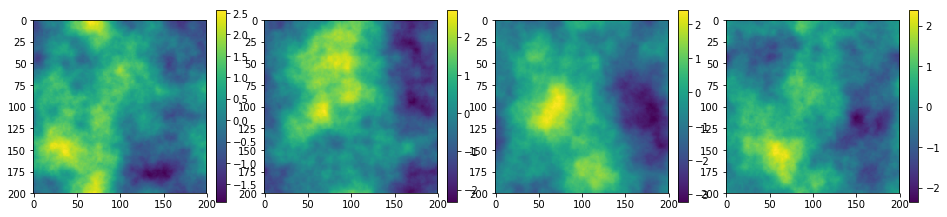

Spatial Size: 200 | Alpha: 4.000
Estimated Alpha: 1.997 | r^2: 0.910


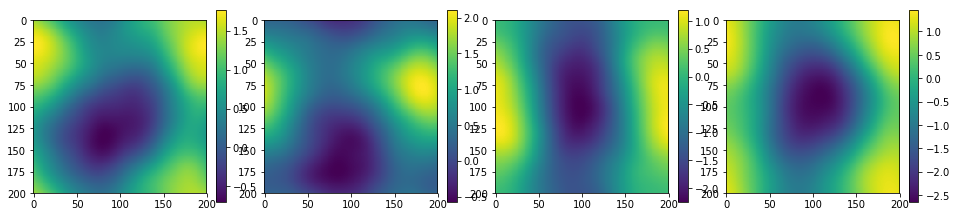

Spatial Size: 400 | Alpha: 1.000
Estimated Alpha: 0.499 | r^2: 0.387


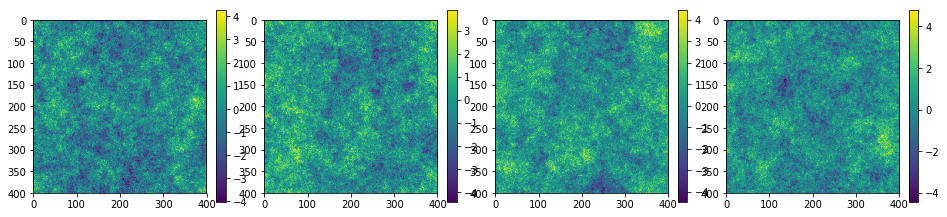

Spatial Size: 400 | Alpha: 2.000
Estimated Alpha: 1.000 | r^2: 0.717


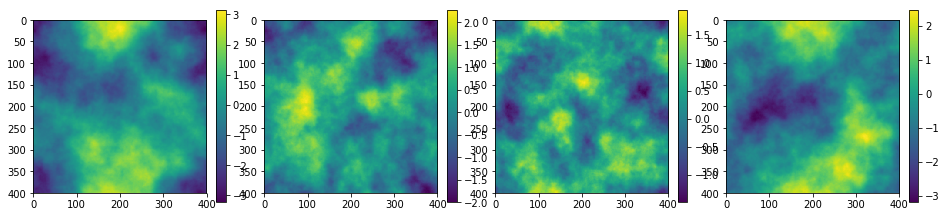

Spatial Size: 400 | Alpha: 4.000
Estimated Alpha: 2.000 | r^2: 0.910


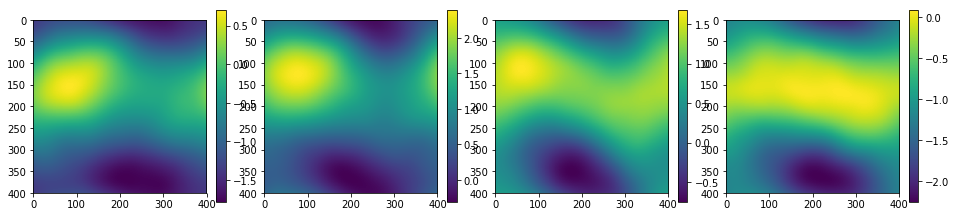

In [30]:
temporalSize=4
for spatialSize in [100, 200, 400]:
    for alpha in [1, 2, 4]:
        data = gaussianRandomSpatialTemporalField(alpha, spatialSize, temporalSize)
        estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data)
        print("Spatial Size: {:d} | Alpha: {:0.3f}".format(spatialSize, alpha))
        print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
        matplotlib.pyplot.figure(figsize=(20, 20))
        for i in range(temporalSize):
            matplotlib.pyplot.subplot(1, temporalSize + 1, i + 1)
            matplotlib.pyplot.imshow(data[:, :, i])
            matplotlib.pyplot.colorbar(fraction=0.05)
        matplotlib.pyplot.show()

In [31]:
_ = gc.collect()

## Successful Techniques

This section will discuss four techniques to analyse large datasets efficiently using SVD.

### Efficient Exact Norm Difference via SVD

In real-world application, one often wants to find the norm of the difference between two fields. This can be done by subtracting one matrix from the other and calculating the norm. However, for large matrices, a more efficient method is available when a rank decomposition, such as the SVD, is already known. The _normDifferenceFromUSVs_ function can take such input SVDs and determine the norm of their difference in an efficient manner, provided the number of singular values is small. The result is mathematically identical to the full calculation, which means that any error will be of the order of machine-precision.

In [32]:
def normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2):
    if U1.shape != U2.shape or s1.shape != s2.shape or Vt1.shape != Vt2.shape:
        print("Error")
        return 0
    AA = s1 @ s1
    BB = s2 @ s2
    AB = s1 @ numpy.multiply(U1.T @ U2, Vt1 @ Vt2.T) @ s2
    return math.sqrt(AA + BB - 2 * AB)

If one is interested in the percentage difference of the second matrix compared with the first, the _percentageNormDifferenceFromUSVs_ function will use the output of the previous function and compare this to the norm of the first matrix, which is simply the sum of its singular values squared.

In [33]:
def percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2):
    return normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2) / math.sqrt(s1 @ s1)

The image below shows that a small number of singular values can lead to simply matrix multiplications, possibly speeding up the calculation.

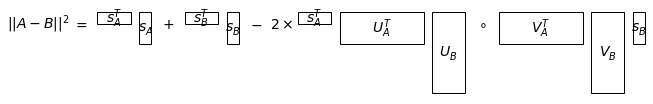

In [34]:
matrixDescription = [
    {"type":"Symbol", "symbol":r"$||A-B||^{2}$", "width":0.5},
    {"type":"Symbol", "symbol":r"$=$"},
    {"type":"Matrix", "width":0.4, "height":0.15, "text":r"$s_{A}^{T}$"},
    {"type":"Matrix", "width":0.15, "height":0.4, "text":r"$s_{A}^{}$"},
    {"type":"Symbol", "symbol":"+"},
    {"type":"Matrix", "width":0.4, "height":0.15, "text":r"$s_{B}^{T}$"},
    {"type":"Matrix", "width":0.15, "height":0.4, "text":r"$s_{B}^{}}$"},
    {"type":"Symbol", "symbol":r"$-$"},
    {"type":"Symbol", "symbol":r"$2 \times$", "width":0.3},
    {"type":"Matrix", "width":0.4, "height":0.15, "text":r"$s_{A}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.4, "text":r"$U_{A}^{T}$"},
    {"type":"Matrix", "width":0.4, "height":1, "text":r"$U_{B}^{}$"},
    {"type":"Symbol", "symbol":r"$\circ$"},
    {"type":"Matrix", "width":1, "height":0.4, "text":r"$V_{A}^{T}$"},
    {"type":"Matrix", "width":0.4, "height":1, "text":r"$V_{B}^{}$"},
    {"type":"Matrix", "width":0.15, "height":0.4, "text":r"$s_{B}^{}$"}
]
plotMatrixMultiplication(matrixDescription, "Results/normDifferenceFromUSVs.pdf")

To verify experimentally that the _normDifferenceFromUSVs_ function indeed produces an output identical to the full norm difference, let's generate a _Gaussian Random Field_ and run both types of calculation.

In [35]:
def testNormDifferenceFromUSVs(size=200, alpha=2):
    matrix1 = gaussianRandomSpatialField(alpha, size)
    matrix2 = gaussianRandomSpatialField(alpha, size)
    matrixDifference = matrix1 - matrix2
    normDifference = scipy.linalg.norm(matrixDifference)
    U1, s1, Vt1 = scipy.linalg.svd(matrix1, full_matrices = False)
    U2, s2, Vt2 = scipy.linalg.svd(matrix2, full_matrices = False)
    normDifference2 = normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)
    return numpy.isclose(normDifference, normDifference2)

As expected, the results are identical up to machine-precision.

In [36]:
testNormDifferenceFromUSVs()

True

In [37]:
_ = gc.collect()

### Efficient Exact SVD via QR Decomposition

In real-world application, one often wants to find the relation between two fields. This can be done by performing an SVD of the cross-correlation matrix of these two fields. In particular, the two input datasets often have the various gridpoint as rows and will have the sample of recorded values over time as columns. Multiplying these gives the cross-correlation matrix. However, for highly rectangular matrices, when there are many spatial gridpoint but few temporal samples, the resulting cross-correlation matrix is inefficiently large and rank deficient. The _qrProductSVD_ function can take such input data and perform an SVD in an efficient manner [2, 5, 15]. The result is mathematically identical to the full SVD, which means that the difference will be at machine-precision.

In [38]:
def qrProductSVD(A, B):
    # Based on a suggestion from Mark Tygert during personal communication [15]
    QA, RA = scipy.linalg.qr(A, mode = "economic")
    QB, RB = scipy.linalg.qr(B, mode = "economic")
    C = RA @ RB.T
    UC, s, VCt = scipy.linalg.svd(C, full_matrices = False)
    U = QA @ UC
    Vt = VCt @ QB.T
    return U, s, Vt

The following figure shows how the rank decomposition leads to a simpler calculation of the SVD.

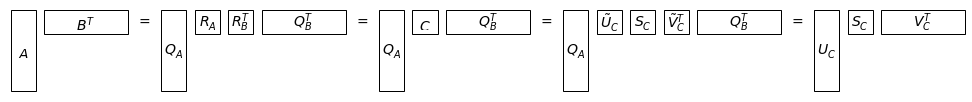

In [39]:
matrixDescription = [
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$B_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$R_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$R_{B}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$C_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{C}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{C}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$V_{C}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/qrProductSVD.pdf")

To verify experimentally that the _qrProductSVD_ function indeed produces an output identical to the full SVD, let's generate a _Gaussian Random Spatio-Temporal Field_ and run both types of SVD.

In [40]:
def testQRProductSVD(spatialSize=60, temporalSize=40, alpha=2):
    matrixBoth = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrix1 = matrixBoth[:, :, :temporalSize]
    matrix2 = matrixBoth[:, :, temporalSize:]
    matrixFlattened1 = matrix1.reshape(spatialSize * spatialSize, temporalSize)
    matrixFlattened2 = matrix2.reshape(spatialSize * spatialSize, temporalSize)
    productMatrix = matrixFlattened1 @ matrixFlattened2.T
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    reconstructedMatrix = usvToMatrix(U, s, Vt)
    return numpy.allclose(productMatrix, reconstructedMatrix)

As expected, the results are identical up to machine-precision.

In [41]:
testQRProductSVD()

True

In [42]:
_ = gc.collect()

### Efficient Approximate SVD via Spatial Coarsening

Although the _qrProductSVD_ function works well for two rectangular matrices, sometimes the input data is large and square. Performing an SVD on such a large dataset will be time consuming and, perhaps, inefficient given the desired level of accuracy.

#### Single Spatial Field via Spatial Coarsening

When a field has large scale structure, the values of neighbouring cells do not change drastically. This is what autocorrelation means. As such, perhaps neighbouring cells can be averaged together to produce a smaller dataset which still faithfully describes the original field. The _matrixToGrid_ function can cut a matrix into multiple smaller sections.

In [43]:
def matrixToGrid(array, nrows, ncols):
    # Based on: https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
    h, w = array.shape
    if h % nrows > 0 or w % ncols > 0:
        print("Shape does not fit")
        return []
    return array.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols)

The _gridToMatrix_ function does the reverse of the previous function and knits together multiple smaller matrices into one large matrix.

In [44]:
def gridToMatrix(gridElements, height=None, width=None):
    heightwidth, nrows, ncols = gridElements.shape
    if width is None or height is None:
        sqrt = math.sqrt(heightwidth)
        if sqrt % 1 > 0:
            print("Shape does not fit")
            return []
        height = int(sqrt) * nrows
        width = int(sqrt) * ncols
    return gridElements.swapaxes(0, 1).reshape(nrows, -1, width).swapaxes(0, 1).reshape(height, width)

The _coarsenMatrix_ function first cuts the input matrix into smaller sections and then averages each section, reducing the spatial size. It then knits the sections back together, resulting in a matrix which is $level^{2}$ times smaller.

In [45]:
def coarsenMatrix(array, level):
    h, w = array.shape
    if h % level > 0:
        array = array[:-(h % level)]
    if w % level > 0:
        array = array[:, :-(w % level)]
    matrixGrid = matrixToGrid(array, level, level)
    c = numpy.nanmean(matrixGrid, axis=(1, 2)).reshape((h // level) * (w // level), 1, 1)
    matrix = gridToMatrix(c, h // level, w // level)
    return matrix

The _uncoarsenMatrix_ function does the reverse of the previous function. It enlarges each cells, resulting in a matrix which is $level^{2}$ times bigger.

In [46]:
def uncoarsenMatrix(matrix, level):
    h, w = matrix.shape
    c = matrixToGrid(matrix, 1, 1)
    c = numpy.tile(c, (1, level, level))
    c = gridToMatrix(c, level * h, level * w)
    return c

To see the effect of spatial coarsening, let's generate a _Gaussian Random Field_ and plot it together with a coarsened version. To be able to compare the two matrices, they need to be of the same size. Therefore, we also uncoarsen the coarsened matrix. The difference with the original field is shown in a plot. To determine precisely how much information is lost during the coarsening, we should look at the variance of the datasets, which are given by the square of their Frobenius norms. As the original dataset was scaled and had size 100, it's norm is 100. The norm of the difference between the uncoarsened matrix and the original is the percentage of information lost in the coarsening process.

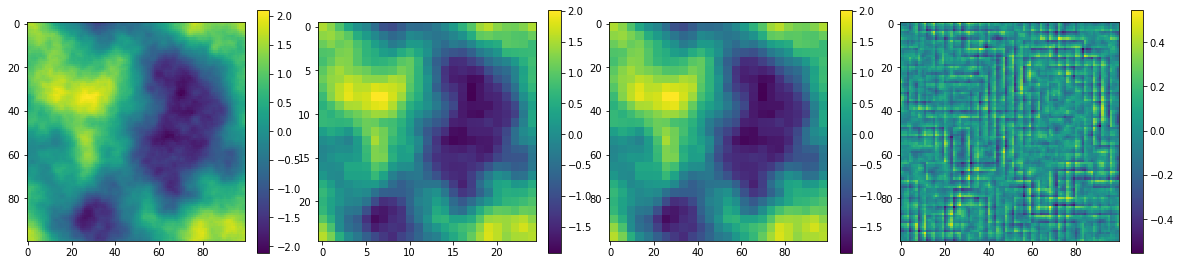

Norm original matrix: 100.0
Norm coarsened matrix: 24.7672673751
Norm uncoarsened matrix: 99.0690695002
Norm of their difference: 13.6132093337
Percentage difference: 0.136132093337


In [47]:
matrix = gaussianRandomSpatialField()
coarsenedMatrix = coarsenMatrix(matrix, 4)
uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrix, 4)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(coarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(uncoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(uncoarsenedMatrix - matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(matrix)
normDifference = scipy.linalg.norm(uncoarsenedMatrix - matrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm coarsened matrix: " + str(scipy.linalg.norm(coarsenedMatrix)))
print("Norm uncoarsened matrix: " + str(scipy.linalg.norm(uncoarsenedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testSingleSpatialFieldViaCoarsening_ function determines the percentage of the information lost in a coarsening process for matrices of various size and $\alpha$'s, and at various window sizes. Often, one is mostly interested in the largest few singular modes. These are the least affected by the coarsening process, as they describe large scale structure within the field. The function includes the parameter _modes_ which reduces the input and output matrix to the largest _modes_ singular values/vectors, to be able to see the information loss specifically on these modes.

In [48]:
def testSingleSpatialFieldViaCoarsening(size=200, alpha=2, level=4, modes=4):
    matrix = gaussianRandomSpatialField(alpha=alpha, size=size)
    coarsenedMatrix = coarsenMatrix(matrix, level)
    coarsenedMatrixReduced = reduceMatrix(coarsenedMatrix, modes)
    uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrixReduced, level)
    matrixReduced = reduceMatrix(matrix, modes)
    return scipy.linalg.norm(uncoarsenedMatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

At a coarsening level of 4, the coarsened matrix is 16 times smaller than the original. One could expect a large portion of the information to be lost, but this is not necessarily the case.

In [49]:
loop(testSingleSpatialFieldViaCoarsening)

0.062177049705750068

There is some effect of size on the error.

In [50]:
loop(testSingleSpatialFieldViaCoarsening, {"size": 100})

0.11665899806691518

In [51]:
loop(testSingleSpatialFieldViaCoarsening, {"size": 400})

0.027692912278291553

The effect of $\alpha$ is obviously important. Smaller $\alpha$ mean smaller scale structure, which can easily get lost during the coarsening.

In [52]:
loop(testSingleSpatialFieldViaCoarsening, {"alpha": 1})

0.23598023949353034

In [53]:
loop(testSingleSpatialFieldViaCoarsening, {"alpha": 4})

0.037201335562144

Clearly, the level of coarsening is fundamental. It would be especially interesting to see the interplay between $\alpha$ and this level on the information loss.

In [54]:
loop(testSingleSpatialFieldViaCoarsening, {"level": 2})

0.026739755761957994

In [55]:
loop(testSingleSpatialFieldViaCoarsening, {"level": 10})

0.14145059833110646

Finally, as mentioned, one is usually only interested in the largest few singular modes. The largest modes at least affected by coarsening. When more modes are included in the comparison, the percentage of relevent information lost increases.

In [56]:
loop(testSingleSpatialFieldViaCoarsening, {"modes": 2})

0.053274051061178787

In [57]:
loop(testSingleSpatialFieldViaCoarsening, {"modes": 8})

0.068994386724284623

Let's plot the information loss as a function of the coarsening level for various $\alpha$'s.

In [58]:
def plotSingleSpatialFieldViaCoarsening(size=480, modes=4):
    alphas = numpy.arange(0.5, 2.1, 0.25)
    levels = numpy.concatenate((numpy.arange(2, 12.1, 2, dtype=int), numpy.arange(16, 24.1, 4, dtype=int)))
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testSingleSpatialFieldViaCoarsening, {"size": size, "alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 100)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldViaCoarsening.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

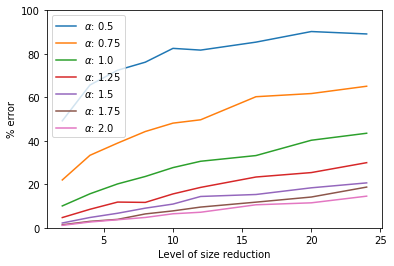

In [59]:
plotSingleSpatialFieldViaCoarsening()

Let's also plot the information loss as a function of the coarsening level for various _modes_.

In [60]:
def plotSingleSpatialFieldViaCoarsening2(size=480, alpha=2):
    modesList = numpy.arange(1, 11.1, 2, dtype=int)
    levels = numpy.arange(4, 24.1, 4, dtype=int)
    for modes in modesList:
        line = []
        for level in levels:
            value = loop(testSingleSpatialFieldViaCoarsening, {"size": size, "alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend(["modes: " + str(modes) for modes in modesList])
    matplotlib.pyplot.ylim(0, 18)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldViaCoarsening2.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

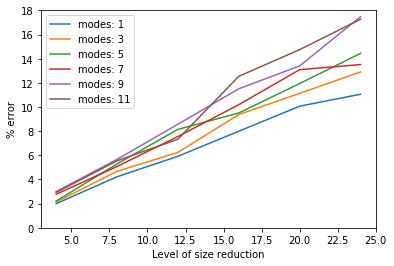

In [61]:
plotSingleSpatialFieldViaCoarsening2()

In [62]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

In the analysis of spatio-temporal fields, the spatial part of each time-slice can be coarsened. The _coarsenMatrix3D_ function simply loops over the temporal dimension and coarsens the spatial part.

In [63]:
def coarsenMatrix3D(array, level):
    h, w, d = array.shape
    coarsenedMatrix3D = numpy.empty((h // level, w // level, d))
    for i in range(d):
        coarsenedMatrix3D[:, :, i] = coarsenMatrix(array[:, :, i], level)
    return coarsenedMatrix3D

In a _CCA_ or _MCA_, the spatio-temporal fields are flattened, scaled and multiplied to obtain the cross-correlation matrix. To undo the effect of coarsening for such a product matrix, the steps are slightly more complicated. The _uncoarsenMatrixProduct_ function performs the two steps of uncoarsening.

In [64]:
def uncoarsenMatrixProduct(matrix, level, hh=None, ww=None):
    h, w = matrix.shape
    if hh is None or ww is None:
        hh = math.sqrt(h)
        ww = math.sqrt(w)
        if hh % 1 != 0 or ww % 1 != 0:
            print("Error")
            return []
        hh = int(hh)
        ww = int(ww)
    matrixGridded = matrixToGrid(matrix, hh, ww)
    matrixTiled = numpy.tile(matrixGridded, (1, level, level))
    matrixReconstructed = gridToMatrix(matrixTiled, level * h, level * w)
    matrixUncoarsened = uncoarsenMatrix(matrixReconstructed, level)
    return matrixUncoarsened

If one want to by-pass the cross-correlation function, the output of the coarsened SVD can also be uncoarsened directly. The _uncoarsenUSV_ function returns the _U_, _s_ and _V_ as if the coarsening had not occured. Note that the vectors are also re-normalised.

In [65]:
def uncoarsenUSV(U, s, Vt, level, height):
    h, w = U.shape
    UGridded = matrixToGrid(U, height, w)
    UTiled = numpy.tile(UGridded, (level, 1))
    UReconstructed = gridToMatrix(UTiled, level * h, w)
    UGridded = matrixToGrid(UReconstructed, 1, w)
    UTiled = numpy.tile(UGridded, (level, 1))
    UReconstructed = gridToMatrix(UTiled, level * level * h, w) / level
    V = Vt.T
    h, w = V.shape
    VGridded = matrixToGrid(V, height, w)
    VTiled = numpy.tile(VGridded, (level, 1))
    VReconstructed = gridToMatrix(VTiled, level * h, w)
    VGridded = matrixToGrid(VReconstructed, 1, w)
    VTiled = numpy.tile(VGridded, (level, 1))
    VReconstructed = gridToMatrix(VTiled, level * level * h, w) / level
    s = s * level**2
    return UReconstructed, s, VReconstructed.T

To see the effect of spatio-temporal coarsening, let's generate a _Gaussian Random Field_ and plot it together with a coarsened version. To be able to compare the two matrices, they need to be of the same size. Therefore, we also uncoarsen the coarsened matrix. The difference with the original field is shown in a plot. To determine precisely how much information is lost during the coarsening, we should look at the variance of the datasets. The norm of the difference between the uncoarsened matrix and the original is the amount of information lost in the coarsening process.

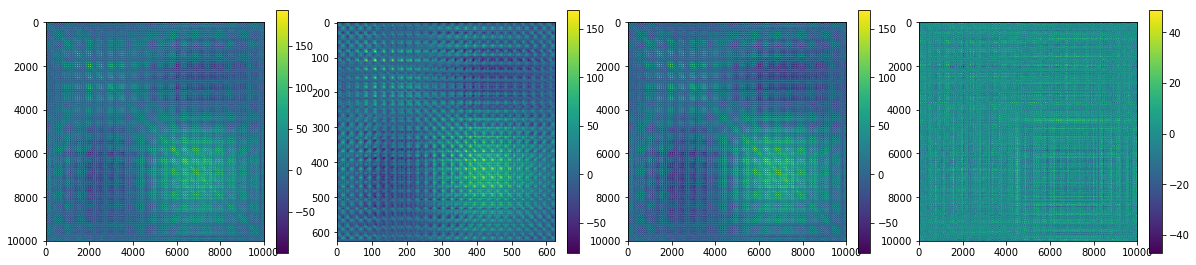

Norm original matrix: 297830.785561
Norm coarsened matrix: 18287.4798819
Norm uncoarsened matrix: 292599.67811
Norm of their difference: 55575.221076
Percentage difference: 0.186599988216


In [66]:
spatialSize=100
temporalSize=60
alpha=2
level=4
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
reconstructedMatrix = usvToMatrix(U1, s1, Vt1)
matrixCombinedCoarsened = coarsenMatrix3D(matrixCombined, level)
matrixCoarsened1, matrixCoarsened2 = splitAndFlattenSpatialTemporalField(matrixCombinedCoarsened)
U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
reconstructedCoarsenedMatrix = usvToMatrix(U2, s2, Vt2)
reconstructedUncoarsenedMatrix = uncoarsenMatrixProduct(reconstructedCoarsenedMatrix, level)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(reconstructedCoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(reconstructedUncoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(reconstructedUncoarsenedMatrix - reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(reconstructedMatrix)
normDifference = scipy.linalg.norm(reconstructedMatrix - reconstructedUncoarsenedMatrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm coarsened matrix: " + str(scipy.linalg.norm(reconstructedCoarsenedMatrix)))
print("Norm uncoarsened matrix: " + str(scipy.linalg.norm(reconstructedUncoarsenedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testProductSpatialTemporalFieldsViaCoarsening_ function determines the percentage of the information lost in a coarsening process for matrices of various sizes and $\alpha$'s, and at various levels of coarsening. The two input matrices used here are similar, as they are generated by the same _Gaussian Random Process_. Therefore, they will correlate highly and the bases in which they are best described will be similar. In principle, any two datasets can be analysed and the amount of information lost during the coarsening process will likely depend on the similarity between the two datasets. This is one aspect which we do not cover here and leave for further research.

In [67]:
def testProductSpatialTemporalFieldsViaCoarsening(spatialSize=100, temporalSize=60, alpha=2, level=4, modes=8):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U1, s1, Vt1 = reduceUSV(U1, s1, Vt1, modes)
    matrixCombinedCoarsened = coarsenMatrix3D(matrixCombined, level)
    matrixCoarsened1, matrixCoarsened2 = splitAndFlattenSpatialTemporalField(matrixCombinedCoarsened)
    U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, modes)
    U2, s2, Vt2 = uncoarsenUSV(U2, s2, Vt2, level, spatialSize // level)
    return percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)

Due to the multiplication step in this analysis, the typical error as a result of coarsening is larger than before.

In [68]:
loop(testProductSpatialTemporalFieldsViaCoarsening)

0.18694575810213504

One could vary both the spatial and the temporal size and examine the effect of the amount of information lost. For simplicity, we only vary the temporal size, which seems to not have a large effect.

In [69]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"temporalSize": 20})

0.18262771622004639

In [70]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"temporalSize": 100})

0.21545305843001086

As before, $\alpha$ plays an important part, with larger $\alpha$'s leading to a less dramatic loss in information due to coarsening.

In [71]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"alpha": 1})

0.85490802056143433

In [72]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"alpha": 4})

0.083361875382209044

The result of varying the level of coarsening is shown below.

In [73]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"level": 2})

0.10608028150204599

In [74]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"level": 10})

0.36957159118899624

Finally, we can again examine the effect of taking into account more or fewer modes.

In [75]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"modes": 4})

0.17936521094373492

In [76]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"modes": 16})

0.20100795975211722

Let's plot the information loss as a function of the coarsening level for various $\alpha$'s. The spatial size is set to a common mutiple of the levels, so that coarsening is straightforward.

In [77]:
def plotProductSpatialTemporalFieldsViaCoarsening(modes=8):
    alphas = numpy.arange(0.5, 2.1, 0.25)
    levels = [2, 4, 8, 12, 16, 24]
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testProductSpatialTemporalFieldsViaCoarsening, {"spatialSize": 96, "alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 105)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotProductSpatialTemporalFieldsViaCoarsening.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

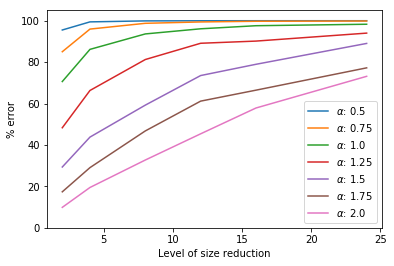

In [78]:
plotProductSpatialTemporalFieldsViaCoarsening()

In [79]:
_ = gc.collect()

### Efficient Approximate SVD via Dimensionality Reduction

The spatial coarsening process is intuitive and easy to implement. It is not, however, the most efficient way to reduce the size of a dataset. Dimensionality reduction refers to discarding modes which contribute little to the variance in a dataset. An SVD is precisely the procedure used to find modes which explain as much variance as possible. Discarding the smallest singular values/vectors is, therefore, the most efficient form of dimensionality reduction. Performing an SVD on a large dataset, however, is computationally costly. The Randomised Dimensionality Reduction process is far more efficient [9, 11, 12].

#### Single Spatial Field via Randomised Dimensionality Reduction

The _reduceSizeRandomisedSquare_ function reduces the input matrix to a smaller square matrix of _l_ by _l_. It also gives two projection matrices which can bring the rows and columns of this smaller matrix back to the bases of the original input. To make the result more precise, the procedure can be repeated multiple times. The parameter _i_ indicates how many loops are performed.

In [80]:
def reduceSizeRandomisedSquare(A, i, l):
    # Based on [11]
    h, w = A.shape
    AW = A @ numpy.random.normal(0, 1, (w, l))
    H, RH = scipy.linalg.qr(AW, mode = "economic")
    ATH = A.T @ H
    W, RW = scipy.linalg.qr(ATH, mode = "economic")
    for _ in range(i):
        AW = A @ W
        H, RH = scipy.linalg.qr(AW, mode = "economic")
        ATH = A.T @ H
        W, RW = scipy.linalg.qr(ATH, mode = "economic")
    L = H.T @ A @ W
    return H, L, W

The _reconstructSquareRandomisedSizeReducedMatrix_ function can take the output of the previous function and reconstruct as much as possible from the original matrix.

In [81]:
def reconstructSquareRandomisedSizeReducedMatrix(H, L, W):
    return H @ L @ W.T

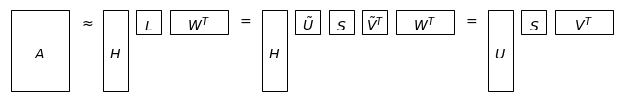

In [82]:
matrixDescription = [
    {"type":"Matrix", "width":0.7, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Symbol", "symbol":r"$\approx$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{}^{}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$W_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{}^{T}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$W_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{}^{}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$V_{}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/reduceSizeRandomisedSquare.pdf")

To see the effect of dimensionality reduction, let's generate a _Gaussian Random Field_ and plot it together with a reduced version. To determine precisely how much information is lost during the reduction, we should look at the variance of the datasets. The norm of the difference between the reduced matrix and the original is the amount of information lost in the reduction process.

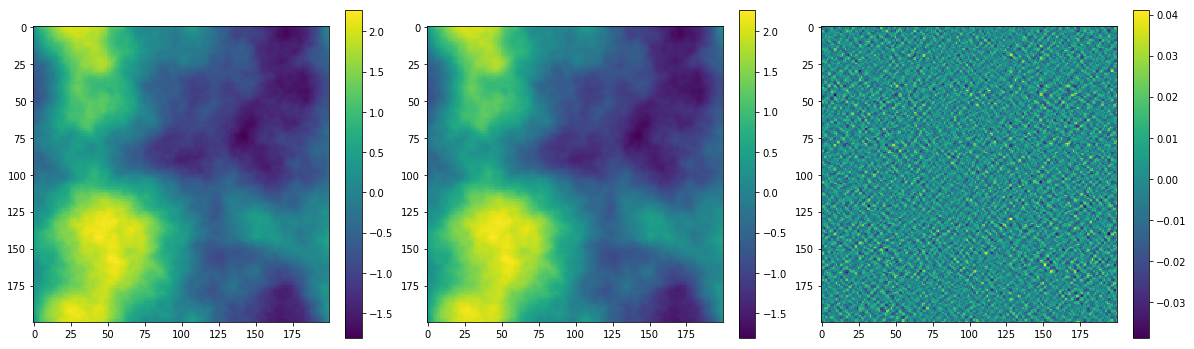

Norm original matrix: 200.0
Norm reduced matrix: 199.991368116
Norm of their difference: 1.85813855998
Percentage difference: 0.00929069279988


In [83]:
size = 200
alpha = 2
level = 4
i = 1
matrix = gaussianRandomSpatialField(alpha, size)
H, L, W = reduceSizeRandomisedSquare(matrix, i, size // level)
reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, L, W)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(reconstructedmatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(reconstructedmatrix - matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(matrix)
normDifference = scipy.linalg.norm(reconstructedmatrix - matrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm reduced matrix: " + str(scipy.linalg.norm(reconstructedmatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testRandomisedSizeReducedMatrix_ function determines the percentage of the information lost in a reduction process for matrices of various sizes and $\alpha$'s, and at various levels of reduction.

In [84]:
def testRandomisedSizeReducedMatrix(size=200, alpha=2, level=4, i=1, modes=4):
    matrix = gaussianRandomSpatialField(alpha, size)
    matrixReduced = reduceMatrix(matrix, modes)
    H, L, W = reduceSizeRandomisedSquare(matrix, i, size // level)
    LReduced = reduceMatrix(L, modes)
    reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, LReduced, W)
    return scipy.linalg.norm(reconstructedmatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

As seen, it is possible for some fields to be represented by matrices of much smaller sizes without losing any substantial amount of information. This is obvious when one realises the singular modes which are removed during the reduction are the smallest ones, described by the tail-end of the power law.

In [85]:
loop(testRandomisedSizeReducedMatrix)

9.6206432433766549e-07

If there is an effect of size, it is small.

In [86]:
loop(testRandomisedSizeReducedMatrix, {"size": 100})

2.2797227492850525e-05

In [87]:
loop(testRandomisedSizeReducedMatrix, {"size": 400})

5.7682388666255223e-08

The tail-end of a power law with a less negative exponent is larger, so the information lost during the reduction of such a field is larger too.

In [88]:
loop(testRandomisedSizeReducedMatrix, {"alpha": 1})

0.0064189001329360189

In [89]:
loop(testRandomisedSizeReducedMatrix, {"alpha": 4})

2.6482113500797594e-14

Clearly, the level of reduction is important.

In [90]:
loop(testRandomisedSizeReducedMatrix, {"level": 2})

4.2295124532207214e-08

In [91]:
loop(testRandomisedSizeReducedMatrix, {"level": 8})

3.4826184910004241e-05

As mentioned, the randomised reduction algorithm includes a loop which makes the projections to lower dimensions more precise. The effect, especially from 0 to 1, seems to be large.

In [92]:
loop(testRandomisedSizeReducedMatrix, {"i": 0})

0.0064041115161885404

In [93]:
loop(testRandomisedSizeReducedMatrix, {"i": 2})

3.7689284367019589e-10

In the review article by Halko, Martinsson and Tropp on randomised dimensionality reduction, it is suggested to oversample the reduction [9]. This is because the error introduced in the process is of the same order as the size of the last sampled singular value. If one is interested in the _k_ dominant modes, reducing to a _k + l_, for some small _l_, rank approximation will ensure the first _k_ modes are approximated quite well. Indeed, as seen below, the more modes one is interested in, the larger the difference compared with the original matrix.

In [94]:
loop(testRandomisedSizeReducedMatrix, {"modes": 2})

1.6945457012449506e-07

In [95]:
loop(testRandomisedSizeReducedMatrix, {"modes": 8})

1.4195660172444056e-05

In [96]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

The Randomised Dimensionality Reduction process can also be applied to the _CCA_ or _MCA_ analysis of two spatio-temporal fields. Similar to the QR Product SVD, it has the advantage that the SVD is applied to a small _l_ by _l_ matrix. The result will be an approximation, but, as we will see, can be close to the real solution.

In [97]:
def randomisedSquareProductSVD(A1, A2, i, l):
    H1, L1, W1 = reduceSizeRandomisedSquare(A1, i, l)
    H2, L2, W2 = reduceSizeRandomisedSquare(A2, i, l)
    C = L1 @ W1.T @ W2 @ L2.T
    UC, s, VCt = scipy.linalg.svd(C, full_matrices = False)
    U = H1 @ UC
    Vt = VCt @ H2.T
    return U, s, Vt

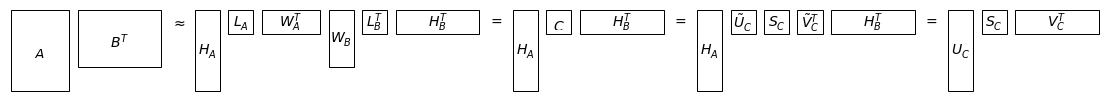

In [98]:
matrixDescription = [
    {"type":"Matrix", "width":0.7, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.7, "text":r"$B_{}^{T}$"},
    {"type":"Symbol", "symbol":r"$\approx$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{A}^{}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$W_{A}^{T}$"},
    {"type":"Matrix", "width":0.3, "height":0.7, "text":r"$W_{B}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{B}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$C_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{C}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{C}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$V_{C}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/randomisedSquareProductSVD.pdf")

To see the effect of dimensionality reduction on such a matrix product, let's generate two _Gaussian Random Fields_ and plot their cross-correlation matrix together with a reduced version. To determine precisely how much information is lost during the reduction, we should look at the variance of the datasets. The norm of the difference between the reduced matrix and the original is the amount of information lost in the reduction process.

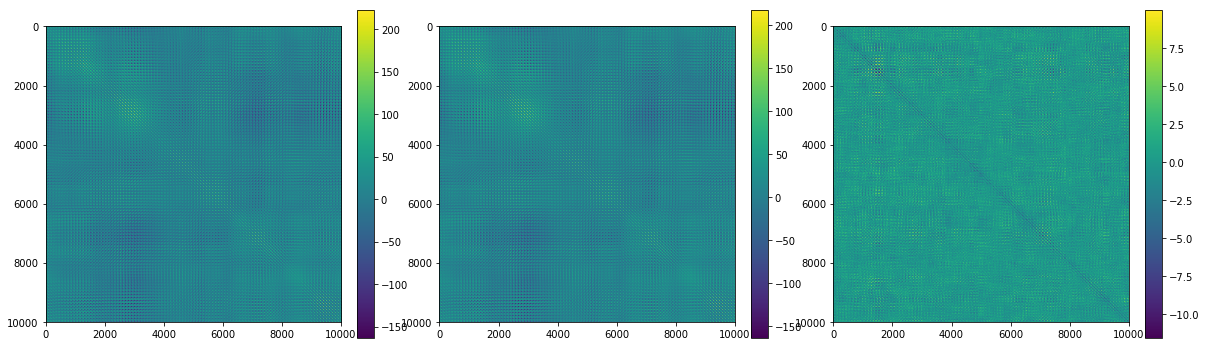

Norm original matrix: 262708.51036
Norm reconstructed matrix: 262493.195256
Norm of their difference: 10634.0895116
Percentage difference: 0.0404786639651


In [99]:
spatialSize=100
temporalSize=60
alpha=2
level=4
i=1
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
reducedMatrix = usvToMatrix(U, s, Vt)
U, s, Vt = randomisedSquareProductSVD(matrixFlattened1, matrixFlattened2, i, int(temporalSize / level))
reconstructedMatrix = usvToMatrix(U, s, Vt)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(reducedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(reconstructedMatrix - reducedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(reducedMatrix)
normDifference = scipy.linalg.norm(reconstructedMatrix - reducedMatrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm reconstructed matrix: " + str(scipy.linalg.norm(reconstructedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testRandomisedSizeReducedMatrixProduct_ function determines the percentage error in a reduction process for matrices of various sizes and $\alpha$'s, and at various levels of reduction. The two input matrices used here are similar, as they are generated by the same _Gaussian Random Process_. Therefore, they will correlate highly and the bases in which they are best described will be similar. In principle, any two datasets can be analysed and the amount of information lost during the coarsening process will likely depend on the similarity between the two datasets. This is one aspect which we do not cover here and leave for further research.

In [100]:
def testRandomisedSizeReducedMatrixProduct(spatialSize=100, temporalSize=60, alpha=2, level=4, i=1, modes=8):
    l = int(temporalSize / level)
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U, s, Vt = reduceUSV(U, s, Vt, min(modes, l))
    U2, s2, Vt2 = randomisedSquareProductSVD(matrixFlattened1, matrixFlattened2, i, l)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, min(modes, l))
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

Due to the multiplication step in this analysis, the typical error as a result of reduction is larger than before.

In [101]:
loop(testRandomisedSizeReducedMatrixProduct)

0.0086603833691770299

There is an affect of temporal size on the error. The _randomisedSquareProductSVD_ function is especially useful for square input matrices. To be able to do the comparisons with the full SVD quickly, we use rectangular matrices here. The larger the temporal size, the more square the input matrices.

In [102]:
loop(testRandomisedSizeReducedMatrixProduct, {"temporalSize": 20})

0.10951363718613238

In [103]:
loop(testRandomisedSizeReducedMatrixProduct, {"temporalSize": 100})

0.0028365398333153116

As before, the scale of the structure of the field influences the information loss. The effect in this case can be quite dramatic. Especially for larger $\alpha$, this procedure performs much better than the coarsening procedure.

In [104]:
loop(testRandomisedSizeReducedMatrixProduct, {"alpha": 1})

0.78716567530445369

In [105]:
loop(testRandomisedSizeReducedMatrixProduct, {"alpha": 4})

5.643780840992485e-07

The level of reduction refers to the portion of the temporal size which is kept. Obviously, highly level reductions leads to worse results.

In [106]:
loop(testRandomisedSizeReducedMatrixProduct, {"level": 2})

0.0018315540423218968

In [107]:
loop(testRandomisedSizeReducedMatrixProduct, {"level": 8})

0.08999480768137938

Again, the number of iterations of the randomised dimensionality reduction procedure can influence the results.

In [108]:
loop(testRandomisedSizeReducedMatrixProduct, {"i": 0})

0.24723770023031177

In [109]:
loop(testRandomisedSizeReducedMatrixProduct, {"i": 2})

0.0033770422840087933

The number of modes of interest also affect the resulting error.

In [110]:
loop(testRandomisedSizeReducedMatrixProduct, {"modes": 4})

0.0046880353120754689

In [111]:
loop(testRandomisedSizeReducedMatrixProduct, {"modes": 16})

0.016013515533061812

Let's plot the error as a function of the reduction level for various $\alpha$'s.

In [112]:
def plotRandomisedSizeReducedMatrixProduct(modes=8):
    alphas = numpy.arange(0.5, 2.1, 0.25)
    levels = numpy.arange(2, 8.1, 1)
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testRandomisedSizeReducedMatrixProduct, {"alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 120)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotRandomisedSizeReducedMatrixProduct.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

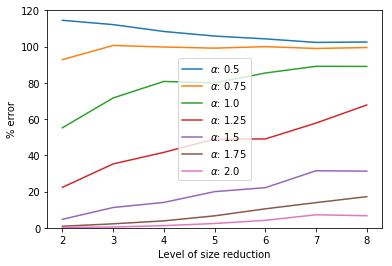

In [113]:
plotRandomisedSizeReducedMatrixProduct()

In [114]:
_ = gc.collect()

### Noise Reduction via Pre-Filtering

The reduction of the number of dimensions of each input dataset is actually advised by some researchers, as a method to filter out noise [1]. Especially  when  the  number of temporal samples is small, outliers and random fluctuations could affect the result [4]. This is because any statistical analysis will choose its regression-coefficients so as to optimize the fit. It may occur that two noise-vectors in the two fields coincidentally covary and show up as dominant modes. Prefiltering can alleviate this risk.

The following sections are not documented well because they were not included in the final article [3].

#### Single Spatial Field

Text

In [115]:
def addNoise(matrix, noiseLevel=1.0):
    return matrix + numpy.random.normal(loc=0.0, scale=noiseLevel, size=matrix.shape)

Text

In [116]:
def testNoiseReduction(size=200, alpha=2, noiseScale=0.1, reduction=3):
    matrix = gaussianRandomSpatialField(alpha, size)
    noiseLevel = noiseScale * numpy.std(matrix)
    matrixNoise = addNoise(matrix, noiseLevel)
    matrixNoiseReduced = reduceMatrix(matrixNoise, size//reduction)
    normMatrix = scipy.linalg.norm(matrix)
    normDifferenceMatrixNoise = scipy.linalg.norm(matrix - matrixNoise)
    normDifferenceMatrixNoiseReduced = scipy.linalg.norm(matrix - matrixNoiseReduced)
    percentageNormDifference1 = normDifferenceMatrixNoise / normMatrix
    percentageNormDifference2 = normDifferenceMatrixNoiseReduced / normMatrix
    percentageNormDifference3 = normDifferenceMatrixNoiseReduced / normDifferenceMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [117]:
loop(testNoiseReduction)

array([ 0.09968394,  0.08515272,  0.85423072])

In [118]:
loop(testNoiseReduction, {"size": 100})

array([ 0.10035315,  0.0857414 ,  0.85441985])

In [119]:
loop(testNoiseReduction, {"size": 400})

array([ 0.09995654,  0.08548352,  0.85520783])

In [120]:
loop(testNoiseReduction, {"alpha": 1})

array([ 0.09989789,  0.26101159,  2.61276795])

In [121]:
loop(testNoiseReduction, {"alpha": 4})

array([ 0.10009388,  0.08576436,  0.85684041])

In [122]:
loop(testNoiseReduction, {"noiseScale": 0.05})

array([ 0.04996268,  0.04270516,  0.85474165])

In [123]:
loop(testNoiseReduction, {"noiseScale": 0.5})

array([ 0.4997744 ,  0.42782054,  0.856027  ])

In [124]:
loop(testNoiseReduction, {"reduction": 2})

array([ 0.09996842,  0.09430078,  0.94330436])

In [125]:
loop(testNoiseReduction, {"reduction": 4})

array([ 0.09994694,  0.07816415,  0.78205771])

#### Product of Spatial Fields

Text

In [126]:
def testNoiseReductionProduct(size=200, alpha=2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, size, 2)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrix1 = matrixCombined[:, :, 0]
    matrix2 = matrixCombined[:, :, 1]
    productMatrix = matrix1 @ matrix2.T
    productMatrixReconstructed = reduceMatrix(productMatrix, size//reconstruction)
    matrixNoise1 = addNoise(matrix1, noiseLevel)
    matrixNoise2 = addNoise(matrix2, noiseLevel)
    productMatrixNoise = matrixNoise1 @ matrixNoise2.T
    productMatrixNoiseReconstructed = reduceMatrix(productMatrixNoise, size//reconstruction)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, size//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, size//reduction)
    productMatrixNoiseReduced = matrixNoiseReduced1 @ matrixNoiseReduced2.T    
    productMatrixNoiseReducedReconstructed = reduceMatrix(productMatrixNoiseReduced, size//reconstruction)
    normProductMatrix = scipy.linalg.norm(productMatrixReconstructed)
    normDifferenceProductMatrixNoise = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReconstructed)
    normDifferenceProductMatrixNoiseReduced = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReducedReconstructed)
    percentageNormDifference1 = normDifferenceProductMatrixNoise / normProductMatrix
    percentageNormDifference2 = normDifferenceProductMatrixNoiseReduced / normProductMatrix
    percentageNormDifference3 = normDifferenceProductMatrixNoiseReduced / normDifferenceProductMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [127]:
loop(testNoiseReductionProduct)

array([ 0.01825602,  0.01822193,  0.99851351])

In [128]:
loop(testNoiseReductionProduct, {"size": 100})

array([ 0.02603656,  0.02588981,  0.99505891])

In [129]:
loop(testNoiseReductionProduct, {"size": 400})

array([ 0.01465225,  0.01464938,  0.99976555])

In [130]:
loop(testNoiseReductionProduct, {"alpha": 1})

array([ 0.05767287,  0.10176333,  1.75814691])

In [131]:
loop(testNoiseReductionProduct, {"alpha": 4})

array([ 0.01518704,  0.01519772,  1.00064259])

In [132]:
loop(testNoiseReductionProduct, {"noiseScale": 0.05})

array([ 0.01092813,  0.0109331 ,  1.00053843])

In [133]:
loop(testNoiseReductionProduct, {"noiseScale": 0.5})

array([ 0.10889985,  0.1070533 ,  0.98354502])

In [134]:
loop(testNoiseReductionProduct, {"reduction": 2})

array([ 0.01709348,  0.0170746 ,  0.99882004])

In [135]:
loop(testNoiseReductionProduct, {"reduction": 4})

array([ 0.02146949,  0.02144362,  0.99869276])

In [136]:
loop(testNoiseReductionProduct, {"reconstruction": 3})

array([ 0.0195635 ,  0.01952076,  0.99764406])

In [137]:
loop(testNoiseReductionProduct, {"reconstruction": 5})

array([ 0.01911921,  0.01910381,  0.99895776])

#### Product of Spatial Fields with Correlated Noise

Text

In [138]:
def addCorrelatedNoise3D(matrix, noiseLevel=1.0):
    noise = noiseLevel * gaussianRandomSpatialTemporalField(alpha/4, matrix.shape[0], matrix.shape[2])  
    return matrix + noise

Text

In [139]:
def testNoiseReductionCorrelatedNoiseProduct(size=200, alpha=2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, size, 2)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrix1, matrix2 = splitSpatialTemporalField(matrixCombined)
    matrixNoise1, matrixNoise2 = splitSpatialTemporalField(matrixCombinedNoise)
    productMatrix = matrix1[:, :, 0] @ matrix2[:, :, 0].T
    productMatrixReconstructed = reduceMatrix(productMatrix, size//reconstruction)
    productMatrixNoise = matrixNoise1[:, :, 0] @ matrixNoise2[:, :, 0].T
    productMatrixNoiseReconstructed = reduceMatrix(productMatrixNoise, size//reconstruction)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1[:, :, 0], size//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2[:, :, 0], size//reduction)
    productMatrixNoiseReduced = matrixNoiseReduced1 @ matrixNoiseReduced2.T    
    productMatrixNoiseReducedReconstructed = reduceMatrix(productMatrixNoiseReduced, size//reconstruction)
    normProductMatrix = scipy.linalg.norm(productMatrixReconstructed)
    normDifferenceProductMatrixNoise = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReconstructed)
    normDifferenceProductMatrixNoiseReduced = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReducedReconstructed)
    percentageNormDifference1 = normDifferenceProductMatrixNoise / normProductMatrix
    percentageNormDifference2 = normDifferenceProductMatrixNoiseReduced / normProductMatrix
    percentageNormDifference3 = normDifferenceProductMatrixNoiseReduced / normDifferenceProductMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [140]:
loop(testNoiseReductionCorrelatedNoiseProduct)

array([ 0.03398468,  0.03396394,  0.99936808])

In [141]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"size": 100})

array([ 0.05374645,  0.05368984,  0.99886343])

In [142]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"size": 400})

array([ 0.02652934,  0.02652321,  0.99979047])

In [143]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"alpha": 1})

array([ 0.07525673,  0.10517343,  1.39444261])

In [144]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"alpha": 4})

array([ 0.03039468,  0.03036647,  0.99914138])

In [145]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"noiseScale": 0.05})

array([ 0.01873779,  0.0187414 ,  1.00023541])

In [146]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"noiseScale": 0.5})

array([ 0.17892467,  0.17732035,  0.99123645])

In [147]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reduction": 2})

array([ 0.03777989,  0.03777731,  0.99974077])

In [148]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reduction": 4})

array([ 0.034908  ,  0.03486612,  0.99880167])

In [149]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reconstruction": 3})

array([ 0.03791563,  0.03788931,  0.99928348])

In [150]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reconstruction": 5})

array([ 0.03419927,  0.03419139,  0.9997643 ])

#### Product of Spatio-Temporal Fields with Correlated Noise

Text

In [151]:
def testNoiseReductionSpatialTemporalField(spatialSize=100, temporalSize=60, alpha=2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    matrixNoise1, matrixNoise2 = splitAndFlattenSpatialTemporalField(matrixCombinedNoise)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, temporalSize//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, temporalSize//reduction)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    UNoise, sNoise, VtNoise = qrProductSVD(matrixNoise1, matrixNoise2)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = qrProductSVD(matrixNoiseReduced1, matrixNoiseReduced2)
    U, s, Vt = reduceUSV(U, s, Vt, temporalSize//reconstruction)
    UNoise, sNoise, VtNoise = reduceUSV(UNoise, sNoise, VtNoise, temporalSize//reconstruction)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = reduceUSV(UNoiseReduced, sNoiseReduced, VtNoiseReduced, temporalSize//reconstruction)
    percentageNormDifference1 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoise, sNoise, VtNoise)
    percentageNormDifference2 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    percentageNormDifference3 = percentageNormDifferenceFromUSVs(UNoise, sNoise, VtNoise, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [152]:
loop(testNoiseReductionSpatialTemporalField)

array([ 0.03325118,  0.03327086,  0.00145014])

In [153]:
loop(testNoiseReductionSpatialTemporalField, {"temporalSize": 20})

array([ 0.06022497,  0.06268801,  0.01800297])

In [154]:
loop(testNoiseReductionSpatialTemporalField, {"temporalSize": 100})

array([ 0.02934225,  0.02934626,  0.0006351 ])

In [155]:
loop(testNoiseReductionSpatialTemporalField, {"alpha": 1})

array([ 0.11950798,  0.20252349,  0.16480755])

In [156]:
loop(testNoiseReductionSpatialTemporalField, {"alpha": 4})

array([ 0.02678746,  0.02678472,  0.00041656])

In [157]:
loop(testNoiseReductionSpatialTemporalField, {"noiseScale": 0.05})

array([ 0.01869317,  0.01875564,  0.00160956])

In [158]:
loop(testNoiseReductionSpatialTemporalField, {"noiseScale": 0.5})

array([ 0.19126012,  0.19117553,  0.00733313])

In [159]:
loop(testNoiseReductionSpatialTemporalField, {"reduction": 2})

array([ 0.03785765,  0.03786629,  0.00106892])

In [160]:
loop(testNoiseReductionSpatialTemporalField, {"reduction": 4})

array([ 0.03868572,  0.03880295,  0.00324978])

In [161]:
loop(testNoiseReductionSpatialTemporalField, {"reconstruction": 3})

array([ 0.03633859,  0.03640002,  0.00257765])

In [162]:
loop(testNoiseReductionSpatialTemporalField, {"reconstruction": 5})

array([ 0.03610503,  0.03612435,  0.00137848])

#### Product of Standardised Spatio-Temporal Fields with Correlated Noise

Text

In [163]:
def testNoiseReductionSpatialTemporalFieldCorrelation(spatialSize=100, temporalSize=60, alpha=2, noiseScale=0.1, reduction=3, reconstruction=5):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    matrixScaled1 = centerAndStandardiseField(matrixFlattened1)
    matrixScaled2 = centerAndStandardiseField(matrixFlattened2)
    matrixNoise1, matrixNoise2 = splitAndFlattenSpatialTemporalField(matrixCombinedNoise)
    matrixNoiseScaled1 = centerAndStandardiseField(matrixNoise1)
    matrixNoiseScaled2 = centerAndStandardiseField(matrixNoise2)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, temporalSize//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, temporalSize//reduction)
    matrixNoiseReducedScaled1 = centerAndStandardiseField(matrixNoiseReduced1)
    matrixNoiseReducedScaled2 = centerAndStandardiseField(matrixNoiseReduced2)
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    UNoise, sNoise, VtNoise = qrProductSVD(matrixNoiseScaled1, matrixNoiseScaled2)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = qrProductSVD(matrixNoiseReducedScaled1, matrixNoiseReducedScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, temporalSize//reconstruction)
    UNoise, sNoise, VtNoise = reduceUSV(UNoise, sNoise, VtNoise, temporalSize//reconstruction)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = reduceUSV(UNoiseReduced, sNoiseReduced, VtNoiseReduced, temporalSize//reconstruction)
    percentageNormDifference1 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoise, sNoise, VtNoise)
    percentageNormDifference2 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    percentageNormDifference3 = percentageNormDifferenceFromUSVs(UNoise, sNoise, VtNoise, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [164]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation)

array([ 0.06577556,  0.09204121,  0.08296806])

In [165]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"temporalSize": 20})

array([ 0.08670606,  0.310909  ,  0.31325747])

In [166]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"temporalSize": 100})

array([ 0.05264525,  0.05592784,  0.04182575])

In [167]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"alpha": 1})

array([ 0.13139721,  1.24632507,  1.24229889])

In [168]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"alpha": 4})

array([ 0.05366268,  0.03452819,  0.03050252])

In [169]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"noiseScale": 0.05})

array([ 0.02686227,  0.06627634,  0.06422032])

In [170]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"noiseScale": 0.5})

array([ 0.37796482,  0.29574288,  0.32753077])

In [171]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reduction": 2})

array([ 0.05203044,  0.05336938,  0.03521194])

In [172]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reduction": 4})

array([ 0.05988781,  0.10926784,  0.10805063])

In [173]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reconstruction": 3})

array([ 0.06513914,  0.08476994,  0.07568125])

In [174]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reconstruction": 5})

array([ 0.05092157,  0.06942159,  0.06543987])

## Real-World Applications

The following section will apply the same techniques to real datasets.

The following sections are not documented well because they were not included in the final article [3].

### Dataset Preperation

Text

In [175]:
def structureMatrix(dataVector, maskFlattened, maskShape):
    structuredMatrix = numpy.full(maskShape[0] * maskShape[1], numpy.nan, dtype=numpy.float64)
    structuredMatrix[maskFlattened] = dataVector
    structuredMatrix = structuredMatrix.reshape(maskShape)
    return structuredMatrix

In [176]:
def structureMatrix3D(dataVectors, maskFlattened, maskShape):
    _, d = dataVectors.shape
    h, w = maskShape
    result = numpy.empty((h, w, d))
    for dd in range(d):
        result[:, :, dd] = structureMatrix(dataVectors[:, dd], maskFlattened, maskShape)
    return result

In [177]:
def plotMatrix(dataVector, maskFlattened, maskShape, filePath = None):
    structuredMatrix = structureMatrix(dataVector, maskFlattened, maskShape)
    matplotlib.pyplot.imshow(structuredMatrix, aspect="auto")
    matplotlib.pyplot.colorbar()
    if filePath is not None:
        matplotlib.pyplot.savefig(filePath)
    matplotlib.pyplot.show()

In [178]:
_ = gc.collect()

In [179]:
maskFlattened = numpy.load("Data/Mask.npz")["maskFlattened"]
maskShape = numpy.load("Data/Mask.npz")["maskShape"]

In [180]:
dataSetBloom = numpy.load("Data/Bloom.npz")["dataSetBloom"]

In [181]:
dataSetSos = numpy.load("Data/Sos.npz")["dataSetSos"]

In [182]:
dataSetBloomFiltered = dataSetBloom[maskFlattened]

In [183]:
dataSetSosFiltered = dataSetSos[maskFlattened]

In [184]:
meanBloom = numpy.nanmean(dataSetBloomFiltered)
stdBloom = numpy.nanstd(dataSetBloomFiltered)
nansBloom = numpy.isnan(dataSetBloomFiltered)
numberOfNaNsBloom = numpy.count_nonzero(nansBloom)
imputedValuesBloom = numpy.random.normal(meanBloom, stdBloom, numberOfNaNsBloom)
dataSetBloomImputed = copy.copy(dataSetBloomFiltered)
dataSetBloomImputed[nansBloom] = imputedValuesBloom

In [185]:
meanSos = numpy.nanmean(dataSetSosFiltered)
stdSos = numpy.nanstd(dataSetSosFiltered)
nansSos = numpy.isnan(dataSetSosFiltered)
numberOfNaNsSos = numpy.count_nonzero(nansSos)
imputedValuesSos = numpy.random.normal(meanSos, stdSos, numberOfNaNsSos)
dataSetSosImputed = copy.copy(dataSetSosFiltered)
dataSetSosImputed[nansSos] = imputedValuesSos

In [186]:
dataSetBloomScaled = centerAndStandardiseField(dataSetBloomImputed)

In [187]:
dataSetSosScaled = centerAndStandardiseField(dataSetSosImputed)

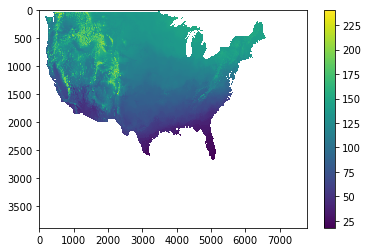

In [188]:
plotMatrix(dataSetBloomImputed[:, 0], maskFlattened, maskShape)

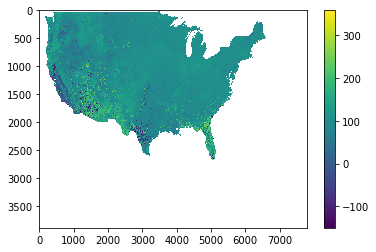

In [189]:
plotMatrix(dataSetSosImputed[:, 0], maskFlattened, maskShape)

In [190]:
structuredMatrixBloom = structureMatrix(dataSetBloomImputed[:, 0], maskFlattened, maskShape)
squareSubMatrixBloom = structuredMatrixBloom[900:1900, 1500:2500]

In [191]:
structuredMatrixSos = structureMatrix(dataSetSosImputed[:, 0], maskFlattened, maskShape)
squareSubMatrixSos = structuredMatrixSos[900:1900, 1500:2500]

Estimated Alpha: 1.378 | r^2: 0.530
Estimated Beta: 3.572 | r^2: 0.875
g.g: 3.979 | g.p_sim_g: 0.001
mi.I: 0.996 | mi.p_rand: 0.000


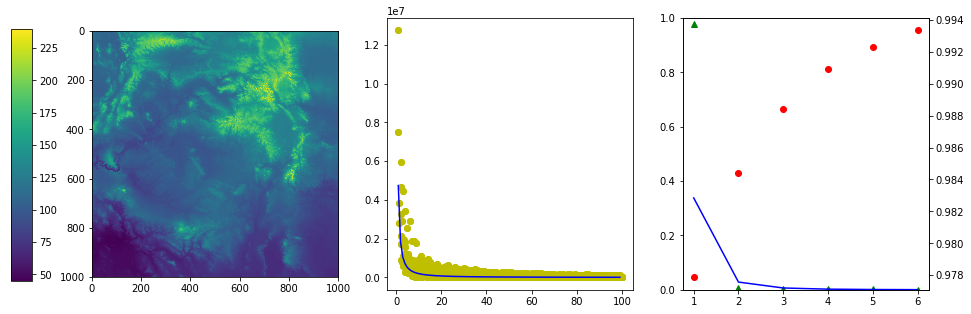

In [192]:
data = squareSubMatrixBloom
size = 1000
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
y = data.flatten()
w = pysal.lat2W(size, size)
g = pysal.Gamma(y, w, standardize="yes")
mi = pysal.Moran(y, w)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
print("g.g: {:0.3f} | g.p_sim_g: {:0.3f}".format(g.g/size**2, g.p_sim_g))
print("mi.I: {:0.3f} | mi.p_rand: {:0.3f}".format(mi.I, mi.p_rand))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked[wavesMasked<100], fftMasked[wavesMasked<100], "yo")
ax2.plot(range(1, 100), math.exp(estimatedIntercept) * numpy.power(range(1, 100), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

Estimated Alpha: 0.606 | r^2: 0.185
Estimated Beta: 1.612 | r^2: 0.750
g.g: 2.380 | g.p_sim_g: 0.001
mi.I: 0.596 | mi.p_rand: 0.000


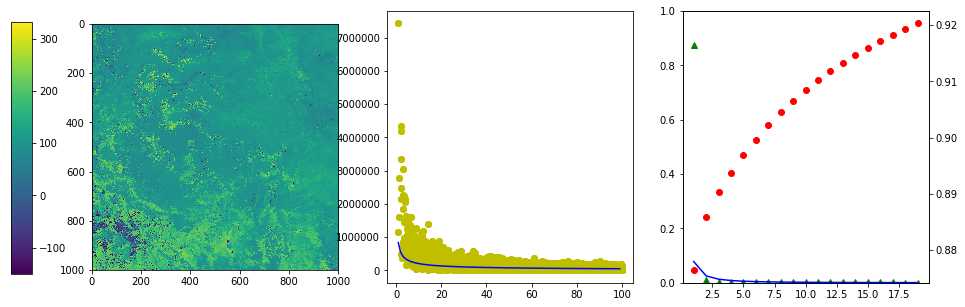

In [193]:
data = squareSubMatrixSos
size = 1000
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
y = data.flatten()
w = pysal.lat2W(size, size)
g = pysal.Gamma(y, w, standardize="yes")
mi = pysal.Moran(y, w)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
print("g.g: {:0.3f} | g.p_sim_g: {:0.3f}".format(g.g/size**2, g.p_sim_g))
print("mi.I: {:0.3f} | mi.p_rand: {:0.3f}".format(mi.I, mi.p_rand))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked[wavesMasked<100], fftMasked[wavesMasked<100], "yo")
ax2.plot(range(1, 100), math.exp(estimatedIntercept) * numpy.power(range(1, 100), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

In [194]:
_ = gc.collect()

### Efficient SVD via Spatial Coarsening

Text

#### Single Spatial Field via Spatial Coarsening

Text

In [195]:
def calculateSingleSpatialFieldViaCoarsening(matrix, level=4, p=4):
    coarsenedMatrix = coarsenMatrix(matrix, level)
    coarsenedMatrixReduced = reduceMatrix(coarsenedMatrix, p)
    uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrixReduced, level)
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(uncoarsenedMatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

In [196]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom)

0.0061095006461294359

Text

In [197]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, level=2)

0.0029784781205488831

In [198]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, level=8)

0.011483692748974358

Text

In [199]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, p=2)

0.004444908432042166

In [200]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, p=8)

0.0086367232342150907

Text

In [201]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos)

0.038878042445821749

Text

In [202]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, level=2)

0.026038557788230887

In [203]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, level=8)

0.064709586527831833

Text

In [204]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, p=2)

0.024818222331836275

In [205]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, p=8)

0.053523417547337117

In [206]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

Text

In [207]:
def uncoarsenMatrix3D(array, level):
    h, w, d = array.shape
    uncoarsenedMatrix3D = numpy.empty((h * level, w * level, d))
    for i in range(d):
        uncoarsenedMatrix3D[:, :, i] = uncoarsenMatrix(array[:, :, i], level)
    return uncoarsenedMatrix3D

In [208]:
def calculateProductSpatialTemporalFieldsViaCoarsening(matrixScaled1, matrixScaled2, maskFlattened, maskShape, level=4, modes=8):
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, modes)
    maskStructured = structureMatrix(maskFlattened[maskFlattened], maskFlattened, maskShape)
    maskCoarsened = ~numpy.isnan(coarsenMatrix(maskStructured, level)).flatten()
    matrixCoarsened1 = coarsenMatrix3D(structureMatrix3D(matrixScaled1, maskFlattened, maskShape), level)
    matrixCoarsened2 = coarsenMatrix3D(structureMatrix3D(matrixScaled2, maskFlattened, maskShape), level)
    matrixCoarsened1, matrixCoarsened2 = flattenSpatialTemporalFields(matrixCoarsened1, matrixCoarsened2)
    matrixCoarsened1 = matrixCoarsened1[maskCoarsened]
    matrixCoarsened2 = matrixCoarsened2[maskCoarsened]
    U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
    U2Restructured = structureMatrix3D(U2, maskCoarsened, (maskShape[0] // level, maskShape[1] // level))
    U2Uncoarsened = uncoarsenMatrix3D(U2Restructured, level)
    U2Uncoarsened = U2Uncoarsened.reshape(maskShape[0] * maskShape[1], U2Restructured.shape[2])[maskFlattened] / level
    V2Restructured = structureMatrix3D(Vt2.T, maskCoarsened, (maskShape[0] // level, maskShape[1] // level))
    V2Uncoarsened = uncoarsenMatrix3D(V2Restructured, level)
    V2Uncoarsened = V2Uncoarsened.reshape(maskShape[0] * maskShape[1], U2Restructured.shape[2])[maskFlattened] / level
    s2Uncoarsened = s2 * level**2
    U2, s2, Vt2 = reduceUSV(U2Uncoarsened, s2Uncoarsened, V2Uncoarsened.T, modes)
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

Text

In [209]:
calculateProductSpatialTemporalFieldsViaCoarsening(dataSetBloomScaled, dataSetSosScaled, maskFlattened, maskShape, level=4, modes=8)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


0.5272806233770936

In [210]:
_ = gc.collect()

Text

In [211]:
calculateProductSpatialTemporalFieldsViaCoarsening(dataSetBloomScaled, dataSetSosScaled, maskFlattened, maskShape, level=2, modes=8)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


0.42929956531761293

In [212]:
_ = gc.collect()

Text

In [213]:
calculateProductSpatialTemporalFieldsViaCoarsening(dataSetBloomScaled, dataSetSosScaled, maskFlattened, maskShape, level=4, modes=4)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


0.5067253983880959

In [214]:
_ = gc.collect()

### Efficient SVD via Randomised Dimensionality Reduction

Text

#### Single Spatial Field via Randomised Dimensionality Reduction

Text

In [215]:
def calculateRandomisedSizeReducedMatrix(matrix, level=4, i=1, modes=8):
    H, L, W = reduceSizeRandomisedSquare(matrix, i, matrix.shape[0] // level)
    LReduced = reduceMatrix(L, modes)
    reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, LReduced, W)
    matrixReduced = reduceMatrix(matrix, modes)
    return scipy.linalg.norm(reconstructedmatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

In [216]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom)

1.0089109082949989e-06

Text

In [217]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, level=2)

5.8644484118451874e-08

In [218]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, level=8)

1.1989343418423269e-05

Text

In [219]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, i=0)

0.0026575123757216225

In [220]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, i=2)

7.2256049636853245e-10

Text

In [221]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, modes=4)

2.2315739511226468e-07

In [222]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, modes=16)

5.3008874868614648e-06

Text

In [223]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos)

0.00085980413065329562

Text

In [224]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, level=2)

9.2767426827697631e-05

In [225]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, level=8)

0.0036164915928164781

Text

In [226]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, i=0)

0.034578179724069041

In [227]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, i=2)

2.668421512905197e-05

Text

In [228]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, modes=4)

0.00044569983939069533

In [229]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, modes=16)

0.002146240756227615

Text

In [230]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

Text

In [231]:
def calculateRandomisedSizeReducedMatrixProduct(matrixScaled1, matrixScaled2, level=4, i=1, modes=8):
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, min(modes, int(temporalSize / level)))
    U2, s2, Vt2 = randomisedSquareProductSVD(matrixScaled1, matrixScaled2, i, int(temporalSize / level))
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, min(modes, int(temporalSize / level)))
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

Text

In [232]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled)

0.3373333559980412

In [233]:
_ = gc.collect()

Text

In [234]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, level=3)

0.2734917914910463

In [235]:
_ = gc.collect()

In [236]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, level=8)

0.6867132827186146

In [237]:
_ = gc.collect()

Text

In [238]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, i=0)

0.5178972462897902

In [239]:
_ = gc.collect()

In [240]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, i=2)

0.3285757907662775

In [241]:
_ = gc.collect()

Text

In [242]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, modes=4)

0.3584153905945383

In [243]:
_ = gc.collect()

In [244]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, modes=16)

0.37749597735293405

In [245]:
_ = gc.collect()

## Unsuccessful Techniques

The following two techniques to perform an SVD in an efficient manner were investigated but were deemed unreliable.

The following sections are not documented well because they were not included in the final article [3].

### Efficient SVD via Grid Analysis

Text

#### Single Spatial Field via Single Grid

Text

In [246]:
def testSVDByGrid(size=200, alpha=2, nrows=20, ncols=20, p=2):
    matrix = gaussianRandomSpatialField(alpha=alpha, size=size)
    matrixGrid = matrixToGrid(matrix, nrows, ncols)
    gridElementsReduced = []
    for gridElement in matrixGrid:
        gridElementsReduced.append(reduceMatrix(gridElement, p))
    matrixReconstructed = gridToMatrix(numpy.array(gridElementsReduced))
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(matrixReconstructed - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

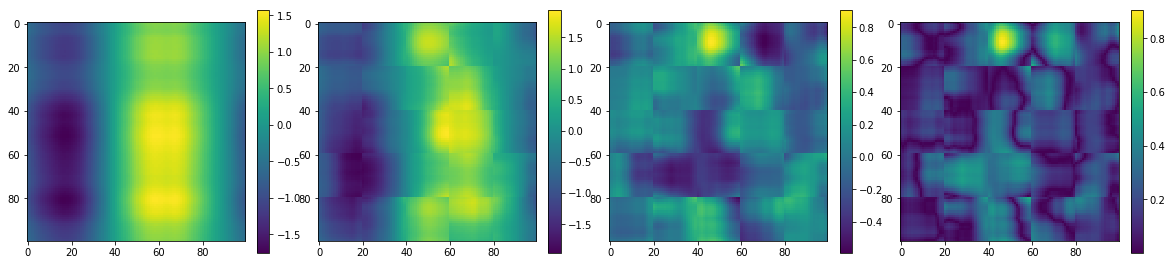

96.3975197214
99.4650532276
24.6592637333


In [247]:
matrix = gaussianRandomSpatialField()
matrixGrid = matrixToGrid(matrix, 20, 20)
gridElementsReduced = []
for gridElement in matrixGrid:
    gridElementsReduced.append(reduceMatrix(gridElement, 1))
matrixReconstructed = gridToMatrix(numpy.array(gridElementsReduced))
matrixReduced = reduceMatrix(matrix, 1)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(matrixReconstructed)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(matrixReconstructed - matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(matrixReconstructed - matrixReduced))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(matrixReduced))
print(scipy.linalg.norm(matrixReconstructed))
print(scipy.linalg.norm(matrixReconstructed - matrixReduced))

Text

In [248]:
loop(testSVDByGrid)

0.30857644665769085

In [249]:
loop(testSVDByGrid, {"size": 100})

0.38237932283394616

In [250]:
loop(testSVDByGrid, {"size": 400})

0.4100426344360058

In [251]:
loop(testSVDByGrid, {"nrows": 10, "ncols": 10})

0.38224953711597526

In [252]:
loop(testSVDByGrid, {"nrows": 40, "ncols": 40})

0.32390292898259126

In [253]:
loop(testSVDByGrid, {"alpha": 1})

1.1127521279115922

In [254]:
loop(testSVDByGrid, {"alpha": 4})

0.060315407768239647

In [255]:
loop(testSVDByGrid, {"p": 1})

0.69831853044424586

In [256]:
loop(testSVDByGrid, {"p": 4})

0.19988152360719202

#### Product of Spatio-Temporal Fields via Single Grid

Text

In [257]:
def matrixToGrid3D(array, gridSize):
    h, w, d = array.shape
    if h % gridSize > 0 or w % gridSize > 0:
        print("Shape does not fit")
        return []
    return array.reshape(h//gridSize, gridSize, -1, gridSize, d).swapaxes(1, 2).reshape(-1, gridSize, gridSize, d)

Text

In [258]:
def gridToMatrix3D(gridElements):
    widthSquared, nrows, ncols, d = gridElements.shape
    width = math.sqrt(widthSquared)
    if width % 1 > 0:
        print("Shape does not fit")
        return []
    width = int(width)
    return gridElements.swapaxes(0, 1).reshape(nrows, -1, width * ncols, d).swapaxes(0, 1).reshape(width * nrows, width * ncols, d)

Text

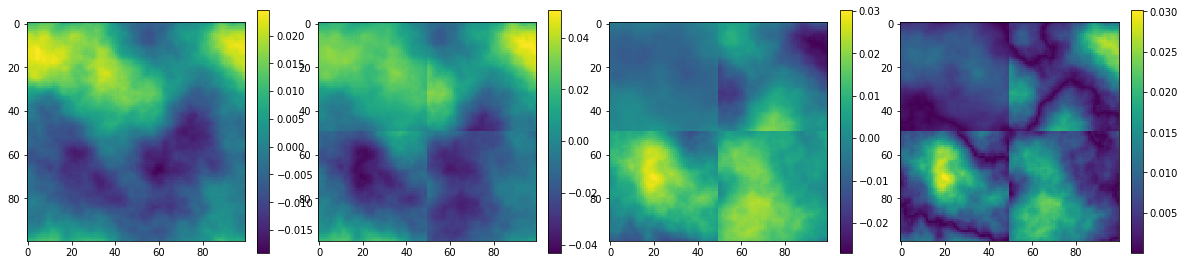

1.0
2.0
1.09736310876


In [259]:
spatialSize=100
temporalSize=60
alpha=2
gridSize=50
number=0
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixSplit1, matrixSplit2 = splitSpatialTemporalField(matrixCombined)
matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixSplit1, matrixSplit2)
U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
UReshaped = U.reshape(spatialSize, spatialSize, temporalSize)
UReshapedExpectedGrid = matrixToGrid3D(UReshaped, gridSize)
matrixGrid1 = matrixToGrid3D(matrixSplit1, gridSize)
matrixGrid2 = matrixToGrid3D(matrixSplit2, gridSize)
gridElementsU = []
for i in range(len(matrixGrid1)):
    matrixFlattenedGrid1, matrixFlattenedGrid2 = flattenSpatialTemporalFields(matrixGrid1[i], matrixGrid2[i])
    UGrid, sGrid, VtGrid = qrProductSVD(matrixFlattenedGrid1, matrixFlattenedGrid2)
    UGridReshaped = UGrid.reshape(gridSize, gridSize, temporalSize)
    sign = []
    for j in range(temporalSize):
        if scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] - UGridReshaped[:, :, j]) > scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] + UGridReshaped[:, :, j]):
            sign.append(-1)
        else:
            sign.append(1)
    gridElementsU.append(UGridReshaped @ numpy.diag(sign))
UReshaped2 = gridToMatrix3D(numpy.array(gridElementsU))
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(UReshaped[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(UReshaped2[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(UReshaped[:, :, number] - UReshaped2[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(UReshaped[:, :, number] - UReshaped2[:, :, number]))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(UReshaped[:, :, number]))
print(scipy.linalg.norm(UReshaped2[:, :, number]))
print(scipy.linalg.norm(UReshaped2[:, :, number] - UReshaped[:, :, number]))

Text

In [260]:
def testProductSVDByGrid(spatialSize=100, temporalSize=60, alpha=2, gridSize=20):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixSplit1, matrixSplit2 = splitSpatialTemporalField(matrixCombined)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixSplit1, matrixSplit2)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    matrixGrid1 = matrixToGrid3D(matrixSplit1, gridSize)
    matrixGrid2 = matrixToGrid3D(matrixSplit2, gridSize)
    gridElementsU = []
    gridElementsV = []
    for i in range(len(matrixGrid1)):
        matrixFlattenedGrid1, matrixFlattenedGrid2 = flattenSpatialTemporalFields(matrixGrid1[i], matrixGrid2[i])
        UGrid, sGrid, VtGrid = qrProductSVD(matrixFlattenedGrid1, matrixFlattenedGrid2)
        gridElementsU.append(UGrid.reshape(gridSize, gridSize, temporalSize))
        gridElementsV.append(VtGrid.T.reshape(gridSize, gridSize, temporalSize))
    UReshaped2 = numpy.array(gridToMatrix3D(numpy.array(gridElementsU))).reshape(spatialSize * spatialSize, temporalSize)
    U2 = sklearn.preprocessing.normalize(UReshaped2, axis=0)
    VReshaped2 = numpy.array(gridToMatrix3D(numpy.array(gridElementsV))).reshape(spatialSize * spatialSize, temporalSize)
    V2 = sklearn.preprocessing.normalize(VReshaped2, axis=0)
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s, V2.T)

Text

In [261]:
loop(testProductSVDByGrid)

1.3216748589822342

In [262]:
loop(testProductSVDByGrid, {"temporalSize": 20})

1.343410090636961

In [263]:
loop(testProductSVDByGrid, {"temporalSize": 100})

1.3235964918499379

In [264]:
loop(testProductSVDByGrid, {"gridSize": 10})

1.3688586246774221

In [265]:
loop(testProductSVDByGrid, {"gridSize": 50})

1.1675909229080066

In [266]:
loop(testProductSVDByGrid, {"alpha": 1})

1.3859219845256647

In [267]:
loop(testProductSVDByGrid, {"alpha": 4})

1.3195068286673128

### Efficient SVD via Moving Grid Analysis

Text

#### Single Spatial Field via Moving Grid

Text

In [268]:
def matrixToFourGrids(dataArray, gridSize):
    halfGridSize = gridSize // 2
    arrayHeight, arrayWidth = dataArray.shape
    if (arrayHeight - halfGridSize) % halfGridSize > 0 or (arrayWidth - halfGridSize) % halfGridSize > 0:
        print("Shape does not fit")
        return []
    subArrays = [
        dataArray[:-halfGridSize, :-halfGridSize],
        dataArray[:-halfGridSize, halfGridSize:],
        dataArray[halfGridSize:, :-halfGridSize],
        dataArray[halfGridSize:, halfGridSize:]
    ]
    result = []
    for subArray in subArrays:
        result.append(matrixToGrid(subArray, gridSize, gridSize))
    return result

Text

In [269]:
def fourGridsToMatrix(subArrays):
    gridHeight, gridWidth = subArrays[0][0].shape
    halfGridHeight = gridHeight // 2
    halfGridWidth = gridWidth // 2
    matrices = []
    for subArray in subArrays:
        matrices.append(gridToMatrix(subArray))
    meanUpper = (matrices[0][:, halfGridWidth:] + matrices[1][:, :-halfGridWidth]) / 2
    concatenatedUpper = numpy.concatenate((matrices[0][:, :halfGridWidth], meanUpper, matrices[1][:, -halfGridWidth:]), axis=1)
    meanLower = (matrices[2][:, halfGridWidth:] + matrices[3][:, :-halfGridWidth]) / 2
    concatenatedLower = numpy.concatenate((matrices[2][:, :halfGridWidth], meanLower, matrices[3][:, -halfGridWidth:]), axis=1)
    mean = (concatenatedUpper[halfGridHeight:, :] + concatenatedLower[:-halfGridHeight, :]) / 2
    result = numpy.concatenate((concatenatedUpper[:halfGridHeight, :], mean, concatenatedLower[-halfGridHeight:, :]), axis=0)
    return result

Text

In [270]:
def testSVDByFourGrids(size=200, alpha=2, gridSize=20, p=2):
    size = size - size % gridSize + gridSize // 2
    matrix = gaussianRandomSpatialField(alpha, size)
    matrixFourGrids = matrixToFourGrids(matrix, gridSize)
    subArrays = []
    for matrixGrid in matrixFourGrids:
        gridElementsReduced = []
        for gridElement in matrixGrid:
            gridElementsReduced.append(reduceMatrix(gridElement, p))
        subArrays.append(numpy.array(gridElementsReduced))
    matrixReconstructed = fourGridsToMatrix(subArrays)
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(matrixReconstructed - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

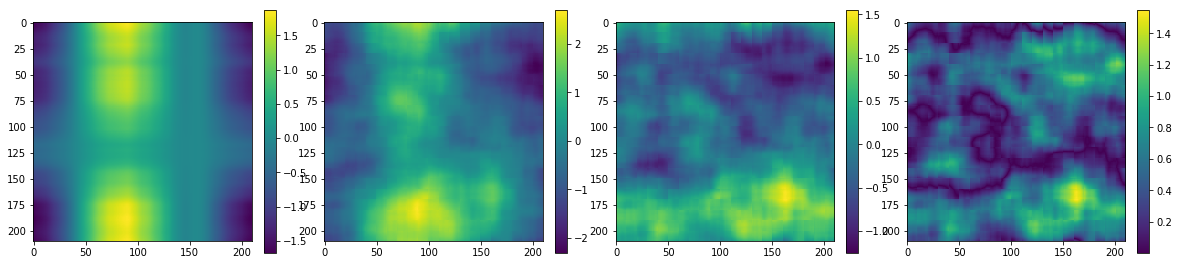

173.030845586
208.836927312
117.399569275


In [271]:
matrix = gaussianRandomSpatialField(size=210)
matrixFourGrids = matrixToFourGrids(matrix, 20)
subArrays = []
for matrixGrid in matrixFourGrids:
    gridElementsReduced = []
    for gridElement in matrixGrid:
        gridElementsReduced.append(reduceMatrix(gridElement, 1))
    subArrays.append(numpy.array(gridElementsReduced))
matrixReconstructed = fourGridsToMatrix(subArrays)
matrixReduced = reduceMatrix(matrix, 1)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(matrixReconstructed)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(matrixReconstructed - matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(matrixReconstructed - matrixReduced))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(matrixReduced))
print(scipy.linalg.norm(matrixReconstructed))
print(scipy.linalg.norm(matrixReconstructed - matrixReduced))

Text

In [272]:
loop(testSVDByFourGrids)

0.36398318487138881

In [273]:
loop(testSVDByFourGrids, {"size": 100})

0.38280748046678603

In [274]:
loop(testSVDByFourGrids, {"size": 400})

0.38054151040313866

In [275]:
loop(testSVDByFourGrids, {"gridSize": 12})

0.36273191722723275

In [276]:
loop(testSVDByFourGrids, {"gridSize": 40})

0.35851694387200089

In [277]:
loop(testSVDByFourGrids, {"alpha": 1})

1.1283144526794353

In [278]:
loop(testSVDByFourGrids, {"alpha": 4})

0.063299621793222891

In [279]:
loop(testSVDByFourGrids, {"p": 1})

0.81970140260767121

In [280]:
loop(testSVDByFourGrids, {"p": 4})

0.16357077284035171

## Bibliography

[1] T. P. Barnett and R. Preisendorfer. 1987. Origins and Levels of Monthly and Seasonal Forecast Skill for US surface Air Temperatures Determined by Canonical Correlation Analysis. Monthly Weather Review 115, 9 (1987), 1825–1850. https://doi.org/10.1175/1520-0493(1987)115<1825:OALOMA>2.0.CO;2

[2] Åke Björck and Gene H. Golub. 1973. Numerical Methods for Computing Angles Between Linear Subspaces. Math. Comp. 27, 123 (1973), 579–594.

[3] Laurens Bogaardt, Romulo Goncalves, Raul Zurita-Milla, and Emma Izquierdo-Verdiguier. 2018. Dataset Reduction Depending on Structure Scale. In Proceedings of SSDBM Conference (SSDBM). https://doi.org/xxx

[4] Christopher S. Bretherton, Catherine Smith, and John M. Wallace. 1992. An Inter-comparison of Methods for Finding Coupled Patterns in Climate Data. Journal of Climate 5, 6 (1992), 541–560. https://doi.org/10.1175/1520-0442(1992)005<0541: AIOMFF>2.0.CO;2

[5] Tony F. Chan. 1982. An Improved Algorithm for Computing the SVD. ACM Trans. Math. Softw. (1982), 72–83. https://doi.org/10.1145/355984.355990

[6] Carl Eckart and Gale Young. 1936. The approximation of one matrix by another of lower rank. Psychometrika (1936), 211–218. https://doi.org/10.1007/BF02288367

[7] Gidon Eshel. 2011. Spatiotemporal Data Analysis. Princeton University Press.

[8] G. H. Golub and C. Reinsch. 1970. Singular Value Decomposition and Least Squares Solutions. Numer. Math. 14 (1970), 403–420. https://doi.org/10.1007/ BF02163027

[9] N. Halko, P. G. Martinsson, and J. A. Tropp. 2011. Finding Structure with Ran- domness: Probabilistic Algorithms for Constructing Approximate Matrix Decom- positions. SIAM Rev. 53, 2 (2011), 217–288. https://doi.org/10.1137/090771806

[10] L. J. Hubert, R. G. Golledge, and C. M. Costanzo. 1981. Generalized Procedures for Evaluating Spatial Autocorrelation. Geographical Analysis 13, 3 (1981), 224–233. https://doi.org/10.1111/j.1538-4632.1981.tb00731.x

[11] Huamin Li, Yuval Kluger, and Mark Tygert. 2016. Randomized algorithms for distributed computation of principal component analysis and singular value decomposition. CoRR abs/1612.08709 (2016). http://arxiv.org/abs/1612.08709

[12] Per-Gunnar Martinsson. 2016. Randomized methods for matrix computations and analysis of high dimensional data. ArXiv (2016). https://arxiv.org/abs/1607.01649

[13] P. A. P. Moran. 1950. Notes on Continuous Stochastic Phenomena. Biometrika 37, 1/2 (1950), 17–23.

[14] Sergio Rey. 2009–2013. PySAL. http://pysal.readthedocs.io. (2009–2013).

[15] Mark Tygert. 2017. Suggested during personal communication. (18 10 2017).

[16] Hans von Storch and Francis W. Zwiers. 1999. Statistical Analysis In Climate Research. Cambridge University Press.